# 12.5 Linear regression and KNN challenge

# Following we use real estate listing data showing which properties are active for sale and which are sold or terminated. We try here to predict those terminated. 
Prior to the prediction, we will perform many cleaning steps and some simple feature engineering. Later we will use different machine learning algorithms for the prediction.
We will use linear regression to create an estimate of market value. And the use that to classify terminated listings to see if overpricing was one of the main reasons of being terminated.

In [3]:
import matplotlib.pyplot as plt
import math
from mlxtend.plotting import plot_decision_regions
import numpy as np
from numpy import percentile
from numpy.random import seed
import os
#from path import Path
import datetime
import time
import re

import pandas as pd
from sqlalchemy import create_engine
from scipy.stats import bartlett
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import levene
from scipy.stats import normaltest
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.stats import zscore
import seaborn as seaborn

In [277]:
import sklearn.datasets
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LassoCV, RidgeCV, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
import time
import warnings
warnings.filterwarnings('ignore')

# Helper Functions 

In [5]:
############################################# DO NOT DELETE ############################################# 

# Help functions to gather basic descriptions
def describe(df):
    return pd.concat([df.describe().T,
                      df.mad().rename('mean abs dev'),
                      df.skew().rename('skew'),
                      df.kurt().rename('kurt'),
                      df.nunique().rename('unique')
                     ], axis=1).T

def data_type_summary(df):
    # get Object data type summary
    df_stat_object = pd.DataFrame([])
    df_stat_object = df.describe(include = ['O'])
    df_stat_object.loc['dtype'] = df.dtypes
    df_stat_object.loc['size'] = len(df)
    df_stat_object.loc['% null'] = df.isnull().mean().round(2)
    
    # get numerical data type summary
    df_stat_num = pd.DataFrame([])
    df_stat_num = df.describe(include = [np.number])
    df_stat_num.loc['dtype'] = df.dtypes
    df_stat_num.loc['size'] = len(df)
    df_stat_num.loc['% null'] = df.isnull().mean().round(2)
    
    # get date data type summary
    df_stat_date = df.describe(include = ['datetime64']) 
    df_stat_date.loc['dtype'] = df.dtypes
    df_stat_date.loc['size'] = len(df)
    df_stat_date.loc['% null'] = df.isnull().mean().round(2)
    
    # Combine all
    result = pd.concat([df_stat_num, df_stat_object,df_stat_date ], axis=1, sort=False)
    return result

In [6]:
############################################# DO NOT DELETE ############################################# 

def describe_with_nulls(df):
    nan_cols = [i for i in df.columns if df[i].isnull().any()]
    # get Object data type summary
    df_stat_num = pd.DataFrame([])
    df_stat_num = df[nan_cols].describe(include = [np.number]) 
    df_stat_num.loc['dtype'] = df.dtypes
    df_stat_num.loc['size'] = len(df)
    df_stat_num.loc['% null'] = df.isnull().mean().round(2)
    return df_stat_num

In [7]:
############################################# DO NOT DELETE ############################################# 

# Finding object attribute names
# Use below to retrieve model estimates for sm regression

# for attr in dir(sm):
#     if not attr.startswith('_'):
#         print(attr)

In [8]:
############################################# DO NOT DELETE ############################################# 
# Function to produce statistics from scikit learn regression estimators
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [7]:
# postgres_user = 'dsbc_student'
# postgres_pw = '7*.8G9QH21'
# postgres_host = '142.93.121.174'
# postgres_port = '5432'
# postgres_db = 'houseprices'

# engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
#     postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# df0 = pd.read_sql_query('select * from houseprices', con=engine)

# # no need for an open connection, 
# # as we're only doing a single query
# engine.dispose()

In [9]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', -1)
#df0 = pd.read_excel (r'C:\Users\00233270\Documents\Projects\data\Billablehoursbyempl_01012018_08192020.xlsx')
#df0 = pd.read_csv (r'C:\Users\00233270\Documents\Projects\data\Thinkful materials\HAR_sample_data.csv')
#df0 = pd.read_csv (r'C:\Users\User\OneDrive - Seedergy\MAEN\Code\Projects\har\HAR_standard_download_20200701_to_20200731.csv')

# Step0_Raw 

In [ ]:
df_import_cols = ['MLS Number', 'Property Type', 'Status', 'Street Number', 'Street Name', 'Unit Number', 'City/Location' \
                  , 'Zip Code', 'County', 'List Price', 'Close Price', 'Close Date', 'Area', 'Subdivision'\
                  , 'Master Planned Community', 'Market Area', 'School District', 'School Elementary', 'School Middle' \
                  , 'School High', 'Building SqFt','Price Sq Ft List', 'Price Sq Ft Sold', 'Lot Size', 'Acres' \
                  , 'Price Acre List', 'Price Acre Sales', 'Year Built', 'Bedrooms','Baths Full', 'Baths Half' \
                  , 'Baths Total', 'Room Count', 'Fireplaces Number', 'Stories', 'New Construction', 'New Construction Desc' \
                  , 'Pool Private', 'No Of Garage Cap', 'Style', 'DOM', 'CDOM', 'List Office MLSID', 'List Office Name' \
                  , 'List Agent MLSID', 'List Agent Full Name', 'Selling Office MLSID', 'Selling Office Name', 'Selling Agent MLSID' \
                  , 'Selling Agent Full Name', 'Realist Owner Name', 'Last Change Timestamp', 'List Date ']

In [ ]:
#path = os.getcwd()
path = 'G:\Analytics'
files = os.listdir(path+'\HAR Pipeline\Step0_Raw\Step0_Data')


In [ ]:
path = 'G:\Analytics\HAR Pipeline\Step0_Raw\Step0_Data\\'

df_import = pd.DataFrame()
for f in files:
    #path1 = os.getcwd()+'\\Documents\Projects\data\Thinkful materials\har\\'
    data = pd.read_excel(path+f, sheet_name=0, header= None, skiprows=1, names=df_import_cols)
    df_import = df_import.append(data)

In [ ]:
df_import.shape

In [ ]:
df0 = df_import.copy()

In [ ]:
df0.head()

# Step1_Parse

In [ ]:
# Cleanup columns headings
df0.columns = df0.columns.str.lstrip()
df0.columns = df0.columns.str.rstrip()
df0.columns = df0.columns.str.replace(' ', '_')
df0.columns = df0.columns.str.lower()
# Make the whole dataframe to lower case
df0 = df0.applymap(lambda s:s.lower() if type(s) == str else s)
# Add a column with ones
df0['ones'] = 1
# Create the ratio of lot size as of building size for filling the nans lalter
df0['lot_build_ratio'] = df0['lot_size'].div(df0['building_sqft'].where(df0['lot_size'] != 0, 0 ))#np.nan))
# Get the median of lot size to building size ratio
lot_build_ratio_median = df0.loc[df0['lot_build_ratio'] !='NaN', 'lot_build_ratio'].median()
df0["lot_build_ratio"] = np.where(lot_build_ratio_median =='NaN', lot_build_ratio_median, lot_build_ratio_median)
# Map all all False/True to numeric 0//1
df0 = df0.applymap(lambda x: 1 if x == True else x)
df0 = df0.applymap(lambda x: 0 if x == False else x)

In [ ]:
# Extract the numerical values from string
df0['school_district_num'] = df0['school_district'].str.extract('(\d+)').astype(str)
df0['school_district_num'] = df0['school_district_num'].astype(str).astype(float) 
# Change type to date time
df0["last_change_timestamp"]  = pd.to_datetime(df0["last_change_timestamp"])
df0["list_date"]  = pd.to_datetime(df0["list_date"])
df0["close_date"]  = pd.to_datetime(df0["close_date"])
df0["year_built"]  = pd.to_datetime(df0["year_built"])
# Change currency type to float
currency_cols = ['list_price', 'close_price']
df0[currency_cols] = (df0[currency_cols].replace( '[\$,)]','', regex=True ).replace( '[(]','-',   regex=True ).astype(float))
# Drop columns with many missing values
df0 = df0.drop(['unit_number','master_planned_community','new_construction_desc','realist_owner_name','mls_number' ], axis=1)
# Drop calculated values as these can be recalcualted when we fill the missing values
df0 = df0.drop(['fireplaces_number', 'price_sq_ft_list', 'price_sq_ft_sold','price_acre_sales', 'acres', 'price_acre_list' ], axis=1)
df0 = df0.rename(columns={'city/location':'city_location'}, inplace=True)
# Get the shape
nRow, nCol = df0.shape
print(f'There are {nRow} rows and {nCol} columns')


In [ ]:
df0.head()

## Step1_Parse: Save as Tab Separated Values

In [10]:
tsv_export_path = 'G:\Analytics\HAR Pipeline\Step1_Parse\Step1_Data\\'
df0.to_csv(tsv_export_path+'2020-07-01-to-2020-07-31-HAR_dot_com.csv', sep='\t', index=False)

NameError: name 'df0' is not defined

## Step2_Ingest: Essential feature enginieering

In [283]:
#tsv_export_path = 'G:\Analytics\HAR Pipeline\Step1_Parse\Step1_Data\\'
tsv_export_path = r'C:\Users\User\OneDrive - Seedergy\MAEN\Code\Projects\HAR Pipeline\\'
s2_df0 = pd.read_csv(tsv_export_path+'2020-07-01-to-2020-07-31-HAR_dot_com.csv', sep='\t', lineterminator='\r')

In [12]:
s2_df0.shape

(36878, 45)

In [14]:
s2_df0 = s2_df0.rename(columns={"city/location": "city_location"}, errors="raise")

In [15]:
s2_df0['property_type'] = s2_df0['property_type'].str.replace('\n','')
s2_df0['property_type'] = s2_df0['property_type'].str.replace('/','_')
s2_df0['property_type'] = s2_df0['property_type'].str.replace('  ',' ')
s2_df0['property_type'] = s2_df0['property_type'].str.replace(' ','_')
s2_df0['property_type'] = s2_df0['property_type'].str.replace('-','_')

In [16]:
s2_df0["last_change_timestamp"]  = pd.to_datetime(s2_df0["last_change_timestamp"])
s2_df0["list_date"]  = pd.to_datetime(s2_df0["list_date"])
s2_df0["close_date"]  = pd.to_datetime(s2_df0["close_date"])
s2_df0["year_built"]  = pd.to_datetime(s2_df0["year_built"])


In [17]:
# Get the data type summary
data_type_summary(s2_df0)

,list_price,close_price,area,building_sqft,lot_size,bedrooms,baths_full,baths_half,baths_total,room_count,stories,new_construction,pool_private,no_of_garage_cap,dom,cdom,ones,lot_build_ratio,school_district_num,property_type,status,street_number,street_name,city_location,zip_code,county,subdivision,market_area,school_district,school_elementary,school_middle,school_high,style,list_office_mlsid,list_office_name,list_agent_mlsid,list_agent_full_name,selling_office_mlsid,selling_office_name,selling_agent_mlsid,selling_agent_full_name,close_date,year_built,last_change_timestamp,list_date
count,36877,18404,36770,32789,30904,33109,33101,32781,36877,33312,31503,33816,33652,33319,36877,36877,36877,36877,36874,36878,36877,36871,36874,36877,36877,36877,35951,34506,36874,36217,36584,36673,28848,36877,36877,36877,36877,21357,21357,21357,21357,18404,33046,36877,36851
mean,290537,224421,23.8899,2408.58,80499.1,3.30082,2.2848,0.50813,2.09601,7.24141,1.68935,0.172551,0.0972008,1.77944,66.5901,102.918,1,3.43483,37.1751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,466462,281203,16.9151,5035.11,5.68212e+06,1.00848,0.860377,0.559762,1.09412,3.42096,12.5815,0.377865,0.296235,3.07901,103.124,176.108,0,1.33229e-15,38.3196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,100,210,1,0,0,0,0,0,0,0,0,0,0,0,-120,-120,1,3.43483,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8900,2400,10,1580,6000,3,2,0,2,5,1,0,0,1,13,15,1,3.43483,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,221500,200000,22,2135,8014,3,2,0,2,7,1.5,0,0,2,43,50,1,3.43483,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,355000,313000,35,2831,12387.2,4,3,1,3,9,2,0,0,2,71,111,1,3.43483,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,1.8e+07,8.0625e+06,87,577327,7.83712e+08,12,20,5,20,29,2214,1,1,468,2590,4748,1,3.43483,271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,datetime64[ns],datetime64[ns],datetime64[ns],datetime64[ns]
size,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878


In [18]:
describe_with_nulls(s2_df0)

,list_price,close_price,area,building_sqft,lot_size,bedrooms,baths_full,baths_half,baths_total,room_count,stories,new_construction,pool_private,no_of_garage_cap,dom,cdom,ones,lot_build_ratio,school_district_num
count,36877,18404,36770,32789,30904,33109,33101,32781,36877,33312,31503,33816,33652,33319,36877,36877,36877,36877,36874
mean,290537,224421,23.8899,2408.58,80499.1,3.30082,2.2848,0.50813,2.09601,7.24141,1.68935,0.172551,0.0972008,1.77944,66.5901,102.918,1,3.43483,37.1751
std,466462,281203,16.9151,5035.11,5.68212e+06,1.00848,0.860377,0.559762,1.09412,3.42096,12.5815,0.377865,0.296235,3.07901,103.124,176.108,0,1.33229e-15,38.3196
min,100,210,1,0,0,0,0,0,0,0,0,0,0,0,-120,-120,1,3.43483,1
25%,8900,2400,10,1580,6000,3,2,0,2,5,1,0,0,1,13,15,1,3.43483,19
50%,221500,200000,22,2135,8014,3,2,0,2,7,1.5,0,0,2,43,50,1,3.43483,27
75%,355000,313000,35,2831,12387.2,4,3,1,3,9,2,0,0,2,71,111,1,3.43483,37
max,1.8e+07,8.0625e+06,87,577327,7.83712e+08,12,20,5,20,29,2214,1,1,468,2590,4748,1,3.43483,271
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
size,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878,36878


In [19]:
s2_df0.describe()

,list_price,close_price,area,building_sqft,lot_size,bedrooms,baths_full,baths_half,baths_total,room_count,stories,new_construction,pool_private,no_of_garage_cap,dom,cdom,ones,lot_build_ratio,school_district_num
count,3.687700e+04,1.840400e+04,36770.000000,32789.000000,3.090400e+04,33109.000000,33101.000000,32781.000000,36877.000000,33312.000000,31503.000000,33816.000000,33652.000000,33319.000000,36877.000000,36877.000000,36877.0,3.687700e+04,36874.000000
mean,2.905365e+05,2.244207e+05,23.889856,2408.580073,8.049908e+04,3.300825,2.284795,0.508130,2.096014,7.241415,1.689347,0.172551,0.097201,1.779435,66.590070,102.917889,1.0,3.434826e+00,37.175083
std,4.664618e+05,2.812027e+05,16.915114,5035.107332,5.682120e+06,1.008478,0.860377,0.559762,1.094117,3.420964,12.581546,0.377865,0.296235,3.079007,103.123773,176.108155,0.0,1.332286e-15,38.319611
min,1.000000e+02,2.100000e+02,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-120.000000,-120.000000,1.0,3.434826e+00,1.000000
25%,8.900000e+03,2.400000e+03,10.000000,1580.000000,6.000000e+03,3.000000,2.000000,0.000000,2.000000,5.000000,1.000000,0.000000,0.000000,1.000000,13.000000,15.000000,1.0,3.434826e+00,19.000000
50%,2.215000e+05,2.000000e+05,22.000000,2135.000000,8.014000e+03,3.000000,2.000000,0.000000,2.000000,7.000000,1.500000,0.000000,0.000000,2.000000,43.000000,50.000000,1.0,3.434826e+00,27.000000
75%,3.550000e+05,3.130000e+05,35.000000,2831.000000,1.238725e+04,4.000000,3.000000,1.000000,3.000000,9.000000,2.000000,0.000000,0.000000,2.000000,71.000000,111.000000,1.0,3.434826e+00,37.000000
max,1.800000e+07,8.062500e+06,87.000000,577327.000000,7.837118e+08,12.000000,20.000000,5.000000,20.000000,29.000000,2214.000000,1.000000,1.000000,468.000000,2590.000000,4748.000000,1.0,3.434826e+00,271.000000


## Step2_Ingest: Convert categorial data to binary 

In [20]:
s2_df0.head(2)

,property_type,status,street_number,street_name,city_location,zip_code,county,list_price,close_price,close_date,area,subdivision,market_area,school_district,school_elementary,school_middle,school_high,building_sqft,lot_size,year_built,bedrooms,baths_full,baths_half,baths_total,room_count,stories,new_construction,pool_private,no_of_garage_cap,style,dom,cdom,list_office_mlsid,list_office_name,list_agent_mlsid,list_agent_full_name,selling_office_mlsid,selling_office_name,selling_agent_mlsid,selling_agent_full_name,last_change_timestamp,list_date,ones,lot_build_ratio,school_district_num
0,rental,active,12150,old county,willis,77378,montgomery,650.0,NaN,NaT,19.0,lonis geo w,conroe northeast,56 - willis,a.r. turner elementary school,robert p. brabham middle school,willis high school,NaN,NaN,1970-01-01 00:00:00.000001985,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,other style,69.0,69.0,jine03,"texas home group, realtors",mpriest,michelle priest,NaN,NaN,NaN,NaN,2020-07-03 09:55:30,2020-07-03,1.0,3.434826,56.0
1,rental,active,4811,oakland,houston,77023,harris,675.0,NaN,NaT,4.0,muller add,east end revitalized,27 - houston,cage elementary school,navarro middle school (houston),austin high school (houston),6716.0,10379.0,1970-01-01 00:00:00.000001952,1.0,1.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,NaN,70.0,70.0,ruth01,"ruth longoria, realtors",longoria,ruth longoria,NaN,NaN,NaN,NaN,2020-07-02 14:35:13,2020-07-02,1.0,3.434826,27.0


In [21]:
s2_df0 = pd.get_dummies(data=s2_df0, columns=['status'], prefix=['status'])
s2_df0 = pd.get_dummies(data=s2_df0, columns=['property_type'], prefix=['type'])

In [23]:
#s2_df0['list_stopped'] = s2_df0[s2_df0['status_expired'] ==1] 
#s2_df0.loc[s2_df0.status_expired == 1, 'listing_stopped'] = 1
#s2_df0.loc[(s2_df0['status_expired'] ==1) | (s2_df0['status_terminated' == 1) | (s2_df0['status_withdrawn' == 1), 'list_stopped'] = 1

def binary_value (row):
    if row['status_expired']==1 :
        return 1
    if row['status_expired']==0 :
        return 0    
    if row['status_terminated']==1 :
        return 1
    if row['status_terminated']==0 :
        return 0    
    if row['status_withdrawn']==1 :
        return 1
    if row['status_withdrawn']==0 :
        return 0    

    
#s2_df0['listing_stopped'] = ''
s2_df0['listing_stopped'] = s2_df0.apply(binary_value, axis=1)

In [24]:
s2_df0.head(2)

,street_number,street_name,city_location,zip_code,county,list_price,close_price,close_date,area,subdivision,market_area,school_district,school_elementary,school_middle,school_high,building_sqft,lot_size,year_built,bedrooms,baths_full,baths_half,baths_total,room_count,stories,new_construction,pool_private,no_of_garage_cap,style,dom,cdom,list_office_mlsid,list_office_name,list_agent_mlsid,list_agent_full_name,selling_office_mlsid,selling_office_name,selling_agent_mlsid,selling_agent_full_name,last_change_timestamp,list_date,ones,lot_build_ratio,school_district_num,status_active,status_expired,status_option pending,status_pend cont to show,status_pending,status_sold,status_terminated,status_withdrawn,type_,type_country_homes_acreage,type_lots,type_mid_hi_rise_condo,type_multi_family,type_private_per_seller,type_rental,type_single_family,type_townhouse_condo,listing_stopped
0,12150,old county,willis,77378,montgomery,650.0,NaN,NaT,19.0,lonis geo w,conroe northeast,56 - willis,a.r. turner elementary school,robert p. brabham middle school,willis high school,NaN,NaN,1970-01-01 00:00:00.000001985,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,other style,69.0,69.0,jine03,"texas home group, realtors",mpriest,michelle priest,NaN,NaN,NaN,NaN,2020-07-03 09:55:30,2020-07-03,1.0,3.434826,56.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,4811,oakland,houston,77023,harris,675.0,NaN,NaT,4.0,muller add,east end revitalized,27 - houston,cage elementary school,navarro middle school (houston),austin high school (houston),6716.0,10379.0,1970-01-01 00:00:00.000001952,1.0,1.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,NaN,70.0,70.0,ruth01,"ruth longoria, realtors",longoria,ruth longoria,NaN,NaN,NaN,NaN,2020-07-02 14:35:13,2020-07-02,1.0,3.434826,27.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [25]:
s2_df0[s2_df0['status_expired']==1].head(2)

,street_number,street_name,city_location,zip_code,county,list_price,close_price,close_date,area,subdivision,market_area,school_district,school_elementary,school_middle,school_high,building_sqft,lot_size,year_built,bedrooms,baths_full,baths_half,baths_total,room_count,stories,new_construction,pool_private,no_of_garage_cap,style,dom,cdom,list_office_mlsid,list_office_name,list_agent_mlsid,list_agent_full_name,selling_office_mlsid,selling_office_name,selling_agent_mlsid,selling_agent_full_name,last_change_timestamp,list_date,ones,lot_build_ratio,school_district_num,status_active,status_expired,status_option pending,status_pend cont to show,status_pending,status_sold,status_terminated,status_withdrawn,type_,type_country_homes_acreage,type_lots,type_mid_hi_rise_condo,type_multi_family,type_private_per_seller,type_rental,type_single_family,type_townhouse_condo,listing_stopped
3475,5835,phillips,houston,77091,harris,695.0,NaN,NaT,9.0,mansfield oaks u/r,northwest houston,1 - aldine,anderson academy,drew academy,carver h s for applied tech/engineering/arts,904.0,8776.0,1970-01-01 00:00:00.000001945,2.0,1.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0,traditional,1.0,1.0,maet01,team churgin realty group,tterry,theresa churgin,NaN,NaN,NaN,NaN,2020-07-02 00:10:37,2020-05-06,1.0,3.434826,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3476,1806,w main,houston,77098,harris,700.0,NaN,NaT,16.0,west lancaster place,montrose,27 - houston,poe elementary school,lanier middle school,lamar high school (houston),3040.0,6250.0,1970-01-01 00:00:00.000001960,1.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,NaN,345.0,345.0,txgy01,southwest realty group,kennethl,kenneth li,NaN,NaN,NaN,NaN,2020-07-02 00:10:54,2019-07-22,1.0,3.434826,27.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


## Visualize 

### Use all dataset 

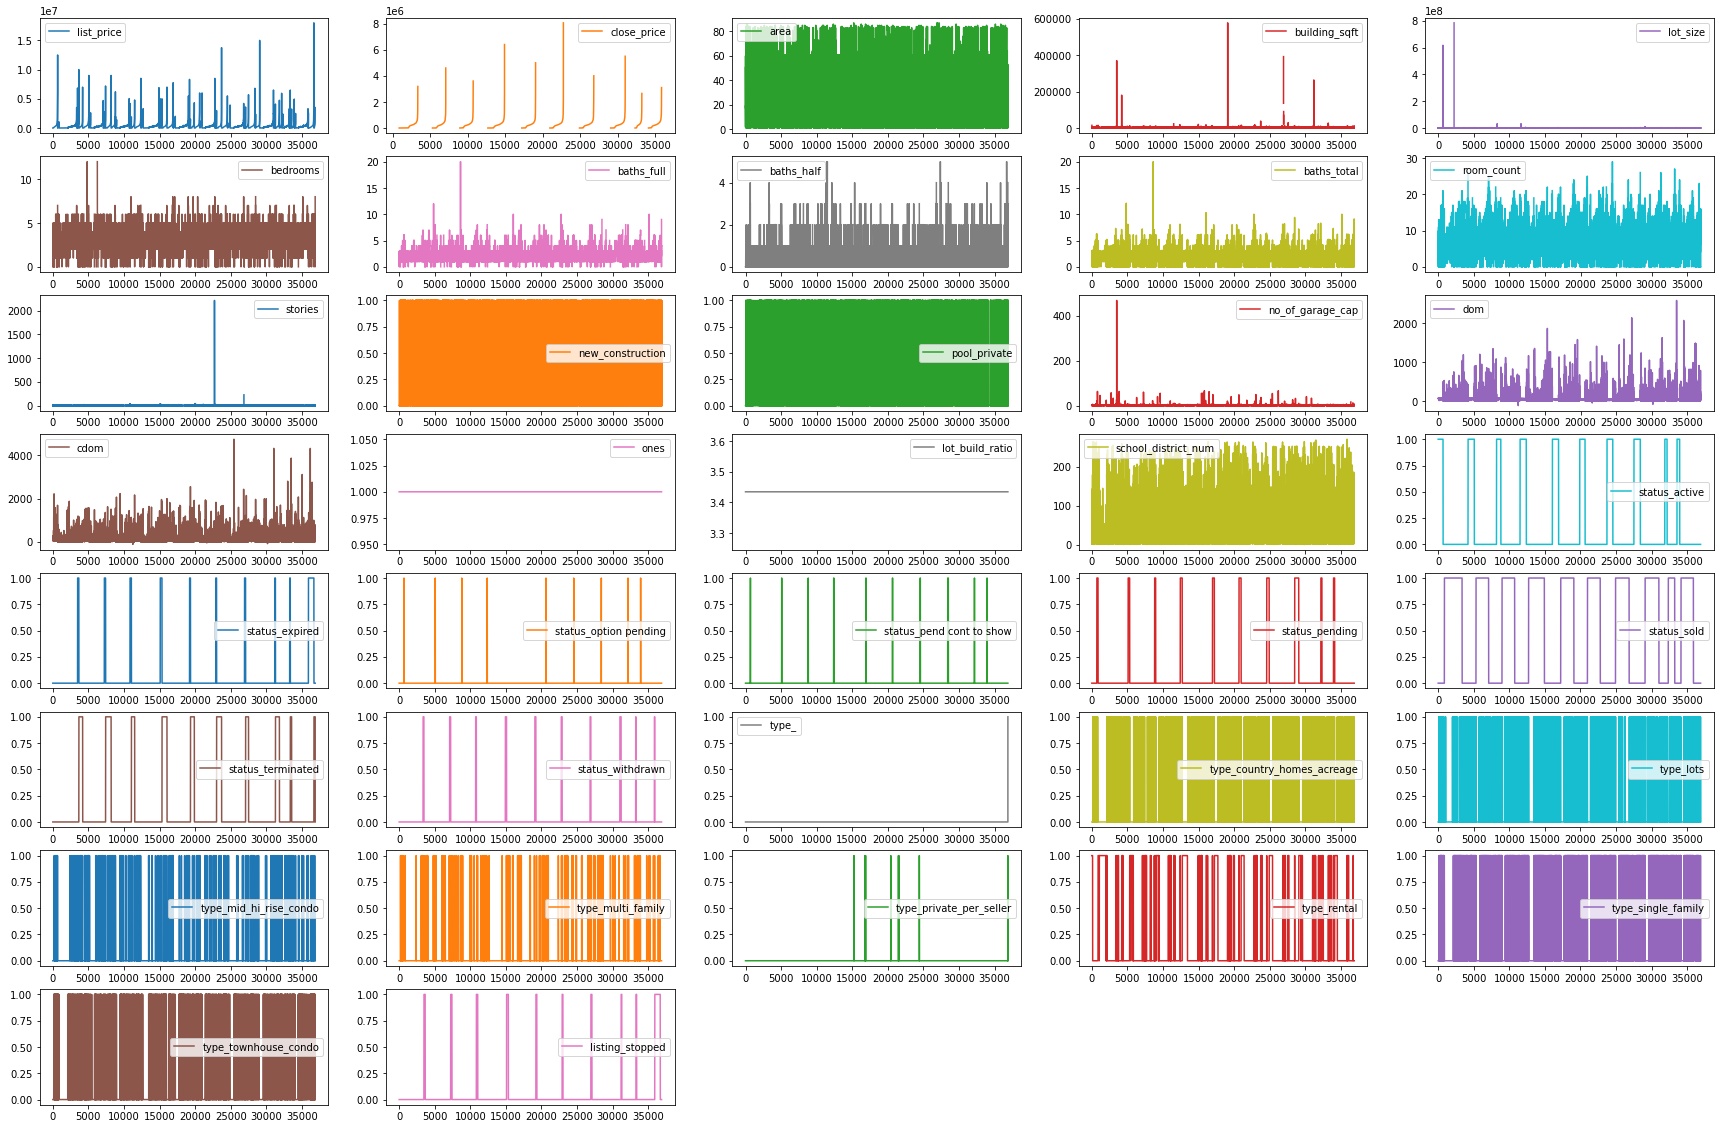

In [26]:
# Get all numerica columns
numerics = ['int_', 'int8', 'uint8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']

s2_df0_num = s2_df0.select_dtypes(include=numerics)
num_cols = s2_df0_num.columns
# Plot all of them
s2_df0[num_cols].plot(subplots=True, layout=(8, 5), figsize=(30, 20), sharex=False);

In [27]:
# #pivot_df = df0.loc[df0['property_type'].isin(['single-family', 'townhouse/condo', 'mid/hi-rise condo'])]
# pivot1 = pd.pivot_table(df0,index=["target", "status", "property_type", ""], values=["list_price"], aggfunc=[len, np.mean, np.median, np.max, np.min], margins=True).round(0)

# # function to pivot showing in 1000$
# def format(x):
#         return "${:.1f}K".format(x/1000)

# # Apply function to specifc columns

# lst = pivot1.columns[1:5]
# for l in lst:
#     pivot1[l] = pivot1[l].apply(format)
    
# pivot1

## Study outliers 

In [28]:
s2_df0.nlargest(5, ['list_price'])

,street_number,street_name,city_location,zip_code,county,list_price,close_price,close_date,area,subdivision,market_area,school_district,school_elementary,school_middle,school_high,building_sqft,lot_size,year_built,bedrooms,baths_full,baths_half,baths_total,room_count,stories,new_construction,pool_private,no_of_garage_cap,style,dom,cdom,list_office_mlsid,list_office_name,list_agent_mlsid,list_agent_full_name,selling_office_mlsid,selling_office_name,selling_agent_mlsid,selling_agent_full_name,last_change_timestamp,list_date,ones,lot_build_ratio,school_district_num,status_active,status_expired,status_option pending,status_pend cont to show,status_pending,status_sold,status_terminated,status_withdrawn,type_,type_country_homes_acreage,type_lots,type_mid_hi_rise_condo,type_multi_family,type_private_per_seller,type_rental,type_single_family,type_townhouse_condo,listing_stopped
36690,16327,grant,cypress,77429,harris,18000000.0,NaN,NaT,35.0,m h bundick,cypress north,13 - cypress-fairbanks,black elementary school (cypress-fairbanks),goodson middle school,cypress woods high school,NaN,1749064.0,NaT,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,395.0,395.0,kwwd01,keller williams realty,csaid,claudine fitzsimmons,NaN,NaN,NaN,NaN,2020-08-01 00:14:33,2019-07-02,1.0,3.434826,13.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
29072,0,northdale,houston,77087,harris,15000000.0,NaN,NaT,3.0,hb prentiss,hobby area,27 - houston,gregg elementary school,hartman middle school,sterling high school (houston),NaN,4939582.0,NaT,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,846.0,846.0,jlar01,jla realty,nafurst,nancy furst,jlar01,jla realty,nafurst,nancy furst,2020-07-29 16:02:17,2017-09-25,1.0,3.434826,27.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
23715,7439,highway 90,navasota,77868,grimes,13750000.0,NaN,NaT,60.0,jesse b mcnealy surv abs #44,NaN,129 - navasota,webb elementary school (navasota),navasota junior high,navasota high school,1704.0,NaN,1970-01-01 00:00:00.000001970,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,26.0,178.0,nvst01,navasota realty,nperry,nancy perry,NaN,NaN,NaN,NaN,2020-07-22 15:15:14,2020-06-26,1.0,3.434826,129.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
677,2,longfellow,houston,77005,harris,12500000.0,NaN,NaT,17.0,shady side,rice/museum district,27 - houston,poe elementary school,lanier middle school,lamar high school (houston),12808.0,75000.0,1970-01-01 00:00:00.000001921,5.0,6.0,3.0,6.3,16.0,2.0,0.0,1.0,3.0,"english, georgian, other style, traditional",69.0,164.0,detx01,douglas elliman real estate,zigm,marc allen ziegler,NaN,NaN,NaN,NaN,2020-07-20 11:46:59,2020-07-03,1.0,3.434826,27.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3653,0,hopfe,hockley,77433,harris,10000000.0,NaN,NaT,35.0,other,hockley,55 - waller,evelyn turlington elementary school,schultz junior high school,waller high school,NaN,NaN,NaT,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,720.0,720.0,tero01,intero real estate services,katelyn,katelyn hayes,NaN,NaN,NaN,NaN,2020-07-02 00:11:03,2018-07-12,1.0,3.434826,55.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [29]:
# Look at bottom n low values
s2_df0.nsmallest(5, ['list_price'])

,street_number,street_name,city_location,zip_code,county,list_price,close_price,close_date,area,subdivision,market_area,school_district,school_elementary,school_middle,school_high,building_sqft,lot_size,year_built,bedrooms,baths_full,baths_half,baths_total,room_count,stories,new_construction,pool_private,no_of_garage_cap,style,dom,cdom,list_office_mlsid,list_office_name,list_agent_mlsid,list_agent_full_name,selling_office_mlsid,selling_office_name,selling_agent_mlsid,selling_agent_full_name,last_change_timestamp,list_date,ones,lot_build_ratio,school_district_num,status_active,status_expired,status_option pending,status_pend cont to show,status_pending,status_sold,status_terminated,status_withdrawn,type_,type_country_homes_acreage,type_lots,type_mid_hi_rise_condo,type_multi_family,type_private_per_seller,type_rental,type_single_family,type_townhouse_condo,listing_stopped
3354,2245,us hwy 77an,yoakum,77995,lavaca,100.0,NaN,NaT,68.0,patrick ryan,NaN,177 - yoakum,NaN,yoakum junior high school,yoakum high school,NaN,NaN,NaT,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,254.0,254.0,kwsw01,keller williams realty -sw,rjansky,robbie jansky,NaN,NaN,NaN,NaN,2020-07-02 15:07:35,2019-09-16,1.0,3.434826,177.0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
31013,1207,grand west blvd,katy,77449,harris,160.0,NaN,NaT,25.0,grand west condos,katy - north,30 - katy,winborn elementary school,morton ranch junior high school,morton ranch high school,841.0,NaN,1970-01-01 00:00:00.000002019,1.0,1.0,0.0,1.0,4.0,NaN,1.0,0.0,0.0,other style,21.0,21.0,swee01,re/max united,josielin,josie lin,NaN,NaN,NaN,NaN,2020-07-27 15:49:44,2020-07-06,1.0,3.434826,30.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
31014,1207,grand west blvd,katy,77449,harris,169.0,NaN,NaT,25.0,grand west condos,katy - north,30 - katy,winborn elementary school,morton ranch junior high school,morton ranch high school,1078.0,NaN,1970-01-01 00:00:00.000002019,2.0,2.0,0.0,2.0,6.0,NaN,1.0,0.0,0.0,other style,21.0,21.0,swee01,re/max united,josielin,josie lin,NaN,NaN,NaN,NaN,2020-07-27 15:48:41,2020-07-06,1.0,3.434826,30.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3654,2601,quitman,houston,77026,harris,250.0,NaN,NaT,9.0,fox & farmer,northside,27 - houston,sherman elementary school,fleming middle school,northside high school,NaN,4800.0,1970-01-01 00:00:00.000001900,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,348.0,348.0,jtrn01,5th stream realty,stubs,stuart scholer,NaN,NaN,NaN,NaN,2020-07-02 23:15:18,2019-02-21,1.0,3.434826,27.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3655,23431,mcspadon,porter,77365,montgomery,380.0,NaN,NaT,40.0,0,porter/new caney east,39 - new caney,porter elementary school (new caney),woodridge forest middle school,porter high school (new caney),NaN,155945.0,NaT,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,121.0,121.0,rmxx01,re/max associates northeast,pporte,paula porterfield,NaN,NaN,NaN,NaN,2020-07-02 16:08:28,2016-11-28,1.0,3.434826,39.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


## Copy to new dataframe 

In [30]:
s2_df1 = s2_df0.copy()

In [31]:
s2_df1.head(1)

,street_number,street_name,city_location,zip_code,county,list_price,close_price,close_date,area,subdivision,market_area,school_district,school_elementary,school_middle,school_high,building_sqft,lot_size,year_built,bedrooms,baths_full,baths_half,baths_total,room_count,stories,new_construction,pool_private,no_of_garage_cap,style,dom,cdom,list_office_mlsid,list_office_name,list_agent_mlsid,list_agent_full_name,selling_office_mlsid,selling_office_name,selling_agent_mlsid,selling_agent_full_name,last_change_timestamp,list_date,ones,lot_build_ratio,school_district_num,status_active,status_expired,status_option pending,status_pend cont to show,status_pending,status_sold,status_terminated,status_withdrawn,type_,type_country_homes_acreage,type_lots,type_mid_hi_rise_condo,type_multi_family,type_private_per_seller,type_rental,type_single_family,type_townhouse_condo,listing_stopped
0,12150,old county,willis,77378,montgomery,650.0,NaN,NaT,19.0,lonis geo w,conroe northeast,56 - willis,a.r. turner elementary school,robert p. brabham middle school,willis high school,NaN,NaN,1970-01-01 00:00:00.000001985,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,other style,69.0,69.0,jine03,"texas home group, realtors",mpriest,michelle priest,NaN,NaN,NaN,NaN,2020-07-03 09:55:30,2020-07-03,1.0,3.434826,56.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [32]:
lower_bound = 400000
upper_bound = 1000000
s2_df2 = s2_df1[((s2_df1['list_price'] >= lower_bound) & (s2_df1['list_price'] <=upper_bound))]
s2_df2 = s2_df2[(s2_df2['type_single_family'] == 1)]

In [33]:
s2_df2.head()

,street_number,street_name,city_location,zip_code,county,list_price,close_price,close_date,area,subdivision,market_area,school_district,school_elementary,school_middle,school_high,building_sqft,lot_size,year_built,bedrooms,baths_full,baths_half,baths_total,room_count,stories,new_construction,pool_private,no_of_garage_cap,style,dom,cdom,list_office_mlsid,list_office_name,list_agent_mlsid,list_agent_full_name,selling_office_mlsid,selling_office_name,selling_agent_mlsid,selling_agent_full_name,last_change_timestamp,list_date,ones,lot_build_ratio,school_district_num,status_active,status_expired,status_option pending,status_pend cont to show,status_pending,status_sold,status_terminated,status_withdrawn,type_,type_country_homes_acreage,type_lots,type_mid_hi_rise_condo,type_multi_family,type_private_per_seller,type_rental,type_single_family,type_townhouse_condo,listing_stopped
468,130,mayfield,montgomery,77316,montgomery,400000.0,NaN,NaT,39.0,woodforest 63,conroe southwest,11 - conroe,stewart elementary school (conroe),peet junior high school,conroe high school,2758.0,8045.0,1970-01-01 00:00:00.000002017,4.0,3.0,0.0,3.0,7.0,2.0,0.0,0.0,3.0,traditional,65.0,65.0,rmxb05,re/max the woodlands & spring,jcm,jeffrey morris,NaN,NaN,NaN,NaN,2020-07-31 11:34:36,2020-07-02,1.0,3.434826,11.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
469,1436,34th 1/2,houston,77018,harris,403094.0,NaN,NaT,9.0,park view at oak forest,oak forest east area,27 - houston,garden oaks elementary school,black middle school,waltrip high school,2111.0,1732.0,1970-01-01 00:00:00.000002020,3.0,3.0,1.0,3.1,5.0,3.0,1.0,0.0,3.0,"contemporary/modern, traditional",65.0,65.0,luch01,luminous custom homes,adtran,ann tran,NaN,NaN,NaN,NaN,2020-09-10 16:21:56,2020-07-03,1.0,3.434826,27.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
470,18706,penn farm,cypress,77433,harris,404802.0,NaN,NaT,25.0,bridgeland,cypress south,13 - cypress-fairbanks,wells elementary school (cypress-fairbanks),smith middle school (cypress-fairbanks),bridgeland high school,2533.0,NaN,1970-01-01 00:00:00.000002020,3.0,3.0,1.0,3.1,7.0,2.0,1.0,0.0,2.0,traditional,70.0,70.0,simm01,trendmaker homes,bsimms,beverly simms,NaN,NaN,NaN,NaN,2020-07-02 14:35:46,2020-07-02,1.0,3.434826,13.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
471,635,langwood,houston,77079,harris,411000.0,NaN,NaT,23.0,thornwood sec 03,energy corridor,30 - katy,wolfe elementary school,memorial parkway junior high school,taylor high school (katy),3279.0,9542.0,1970-01-01 00:00:00.000001970,4.0,2.0,2.0,2.2,10.0,2.0,0.0,0.0,2.0,traditional,69.0,245.0,view01,creekview realty,prell,john prell,NaN,NaN,NaN,NaN,2020-07-03 21:02:04,2020-07-03,1.0,3.434826,30.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
472,1432,34th 1/2,houston,77018,harris,411000.0,NaN,NaT,9.0,park view/oak forest,oak forest east area,27 - houston,garden oaks elementary school,black middle school,waltrip high school,2135.0,1732.0,1970-01-01 00:00:00.000002020,3.0,2.0,1.0,2.1,6.0,3.0,1.0,0.0,2.0,"contemporary/modern, traditional",65.0,374.0,luch01,luminous custom homes,adtran,ann tran,NaN,NaN,NaN,NaN,2020-09-10 16:28:27,2020-07-03,1.0,3.434826,27.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [34]:
s2_df2.shape

(4847, 61)

## Analyze using pivot 

In [35]:
#pivot_df = s2_df0.loc[s2_df0['property_type'].isin(['single-family', 'townhouse/condo', 'mid/hi-rise condo'])]
pivot1 = pd.pivot_table(s2_df2,index=['status_expired','status_terminated', 'status_withdrawn', 'status_sold'], columns=["type_single_family"] \
                        , values=["list_price"], aggfunc=[len, np.mean, np.median, np.max, np.min], margins=False).round(0)

# function to pivot showing in 1000$
def format(x):
        return "${:.1f}K".format(x/1000)

# Apply function to specifc columns

lst = pivot1.columns[3:10]
for l in lst:
    pivot1[l] = pivot1[l].apply(format)

In [36]:
pivot1

len  \
                                                              list_price   
type_single_family                                                     1   
status_expired status_terminated status_withdrawn status_sold              
0              0                 0                0            1534.0      
                                                  1            2146.0      
                                 1                0            147.0       
               1                 0                0            785.0       
1              0                 0                0            235.0       

                                                                    mean  \
                                                              list_price   
type_single_family                                                     1   
status_expired status_terminated status_withdrawn status_sold              
0              0                 0                0            582955.0    
                                                  1            563138.0    
                                 1                0            576351.0    
               1                 0                0            599049.0    
1              0                 0                0            583507.0    

                                                                  median  \
                                                              list_price   
type_single_family                                                     1   
status_expired status_terminated status_withdrawn status_sold              
0              0                 0                0            547430.0    
                                                  1            520000.0    
                                 1                0            549000.0    
               1                 0                0            565000.0    
1              0                 0                0            529000.0    

                                                                    amax  \
                                                              list_price   
type_single_family                                                     1   
status_expired status_terminated status_withdrawn status_sold              
0              0                 0                0            $1000.0K    
                                                  1            $1000.0K    
                                 1                0            $1000.0K    
               1                 0                0            $1000.0K    
1              0                 0                0            $999.0K     

                                                                    amin  
                                                              list_price  
type_single_family                                                     1  
status_expired status_terminated status_withdrawn status_sold             
0              0                 0                0            $400.0K    
                                                  1            $400.0K    
                                 1                0            $400.0K    
               1                 0                0            $400.0K    
1              0                 0                0            $400.0K

In [37]:
#pivot_df = s2_df0.loc[s2_df0['property_type'].isin(['single-family', 'townhouse/condo', 'mid/hi-rise condo'])]
pivot2 = pd.pivot_table(s2_df2,index=["type_single_family"],values=["list_price", "close_price"], aggfunc=[len, np.mean, np.median], margins=True).round(0)

# function to pivot showing in 1000$
def format(x):
        return "${:.1f}K".format(x/1000)

# Apply function to specifc columns

lst = pivot2.columns[2:6]
for l in lst:
    pivot2[l] = pivot2[l].apply(format)

In [38]:
pivot2

len                   mean                 median  \
                   close_price list_price close_price list_price close_price   
type_single_family                                                             
1                   4847.0      4847.0     $547.2K     $576.6K    $505.8K      
All                 2146.0      2146.0     $547.2K     $563.1K    $505.8K      

                               
                   list_price  
type_single_family             
1                   $535.0K    
All                 $520.0K

## Explore and fix any outliers

In [39]:
data_type_summary(s2_df2)

,list_price,close_price,area,building_sqft,lot_size,bedrooms,baths_full,baths_half,baths_total,room_count,stories,new_construction,pool_private,no_of_garage_cap,dom,cdom,ones,lot_build_ratio,school_district_num,status_active,status_expired,status_option pending,status_pend cont to show,status_pending,status_sold,status_terminated,status_withdrawn,type_,type_country_homes_acreage,type_lots,type_mid_hi_rise_condo,type_multi_family,type_private_per_seller,type_rental,type_single_family,type_townhouse_condo,listing_stopped,street_number,street_name,city_location,zip_code,county,subdivision,market_area,school_district,school_elementary,school_middle,school_high,style,list_office_mlsid,list_office_name,list_agent_mlsid,list_agent_full_name,selling_office_mlsid,selling_office_name,selling_agent_mlsid,selling_agent_full_name,close_date,year_built,last_change_timestamp,list_date
count,4847,2146,4837,4827,4533,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4846,4847,4847,4847,4847,4821,4689,4847,4799,4830,4833,4847,4847,4847,4847,4847,2524,2524,2524,2524,2146,4814,4847,4840
mean,576614,547185,23.9868,3365.44,27840.3,3.90324,3.04209,0.817619,3.12385,9.6666,2.32175,0.219724,0.259129,2.37219,68.9785,118.443,1,3.43483,31.653,0.238498,0.0484836,0.000206313,0.00928409,0.068496,0.442748,0.161956,0.030328,0,0,0,0,0,0,0,1,0,0.0484836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,148787,138201,14.1428,1002,101033,0.841262,0.869701,0.55613,0.877664,3.22602,31.7815,0.414102,0.438202,1.30529,79.7155,152.733,0,4.44135e-16,27.2121,0.426209,0.214808,0.0143636,0.0959156,0.252621,0.496763,0.368448,0.171506,0,0,0,0,0,0,0,0,0,0.214808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,400000,308500,1,450,0,0,0,0,0,0,0,0,0,0,0,0,1,3.43483,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,455800,441000,14,2620,7240,3,3,0,3,8,1,0,0,2,21,29,1,3.43483,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,535000,505843,23,3348,9925,4,3,1,3.1,10,2,0,0,2,50,62,1,3.43483,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,664780,616874,33,4012.5,14982,4,3,1,3.2,12,2,0,1,3,79,146,1,3.43483,33,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,1e+06,1.03e+06,85,11365,3.67298e+06,7,20,5,20,29,2214,1,1,48,959,1703,1,3.43483,264,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,datetime64[ns],datetime64[ns],datetime64[ns],datetime64[ns]
size,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847,4847


In [41]:
s2_df2['lot_size'] = s2_df2['lot_size'].fillna(s2_df2['lot_build_ratio'] * s2_df2['building_sqft'])#, inplace=True)

In [42]:
s2_df2.shape

(4847, 61)

In [43]:
# Remove very few rows with null values
s2_df2 = s2_df2.dropna(axis=0, subset=['area', 'building_sqft', 'lot_size', 'room_count'])

In [44]:
s2_df2.shape

(4819, 61)

In [45]:
# Get all numerica columns
numerics = ['int_', 'int8', 'uint8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
s2_df2_num = s2_df2.select_dtypes(include=numerics)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37]),
 <a list of 37 Text major ticklabel objects>)

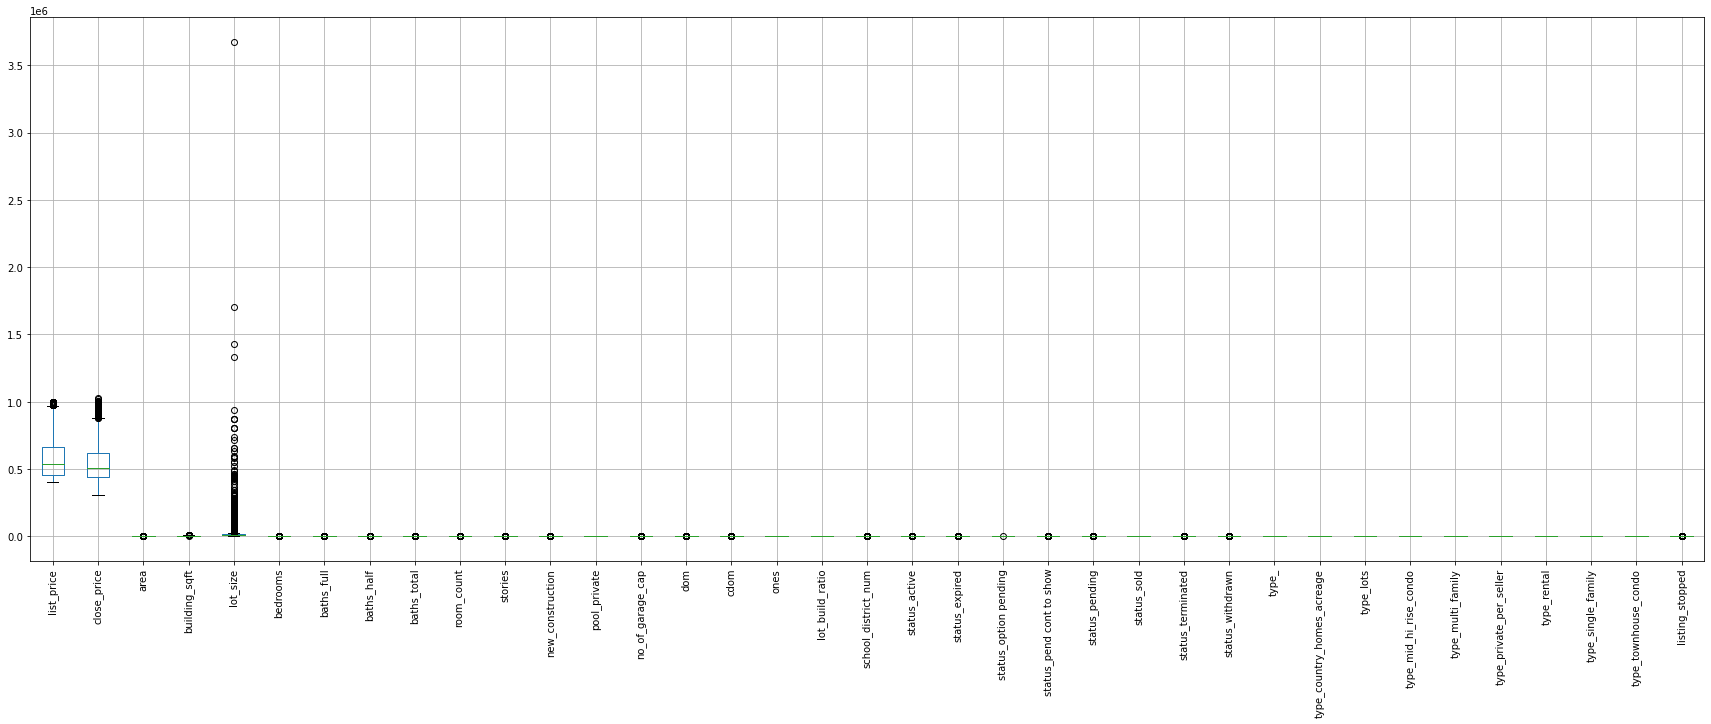

In [46]:
plt.figure(figsize = (30,10))
s2_df2_num.boxplot()
plt.xticks(rotation=90)

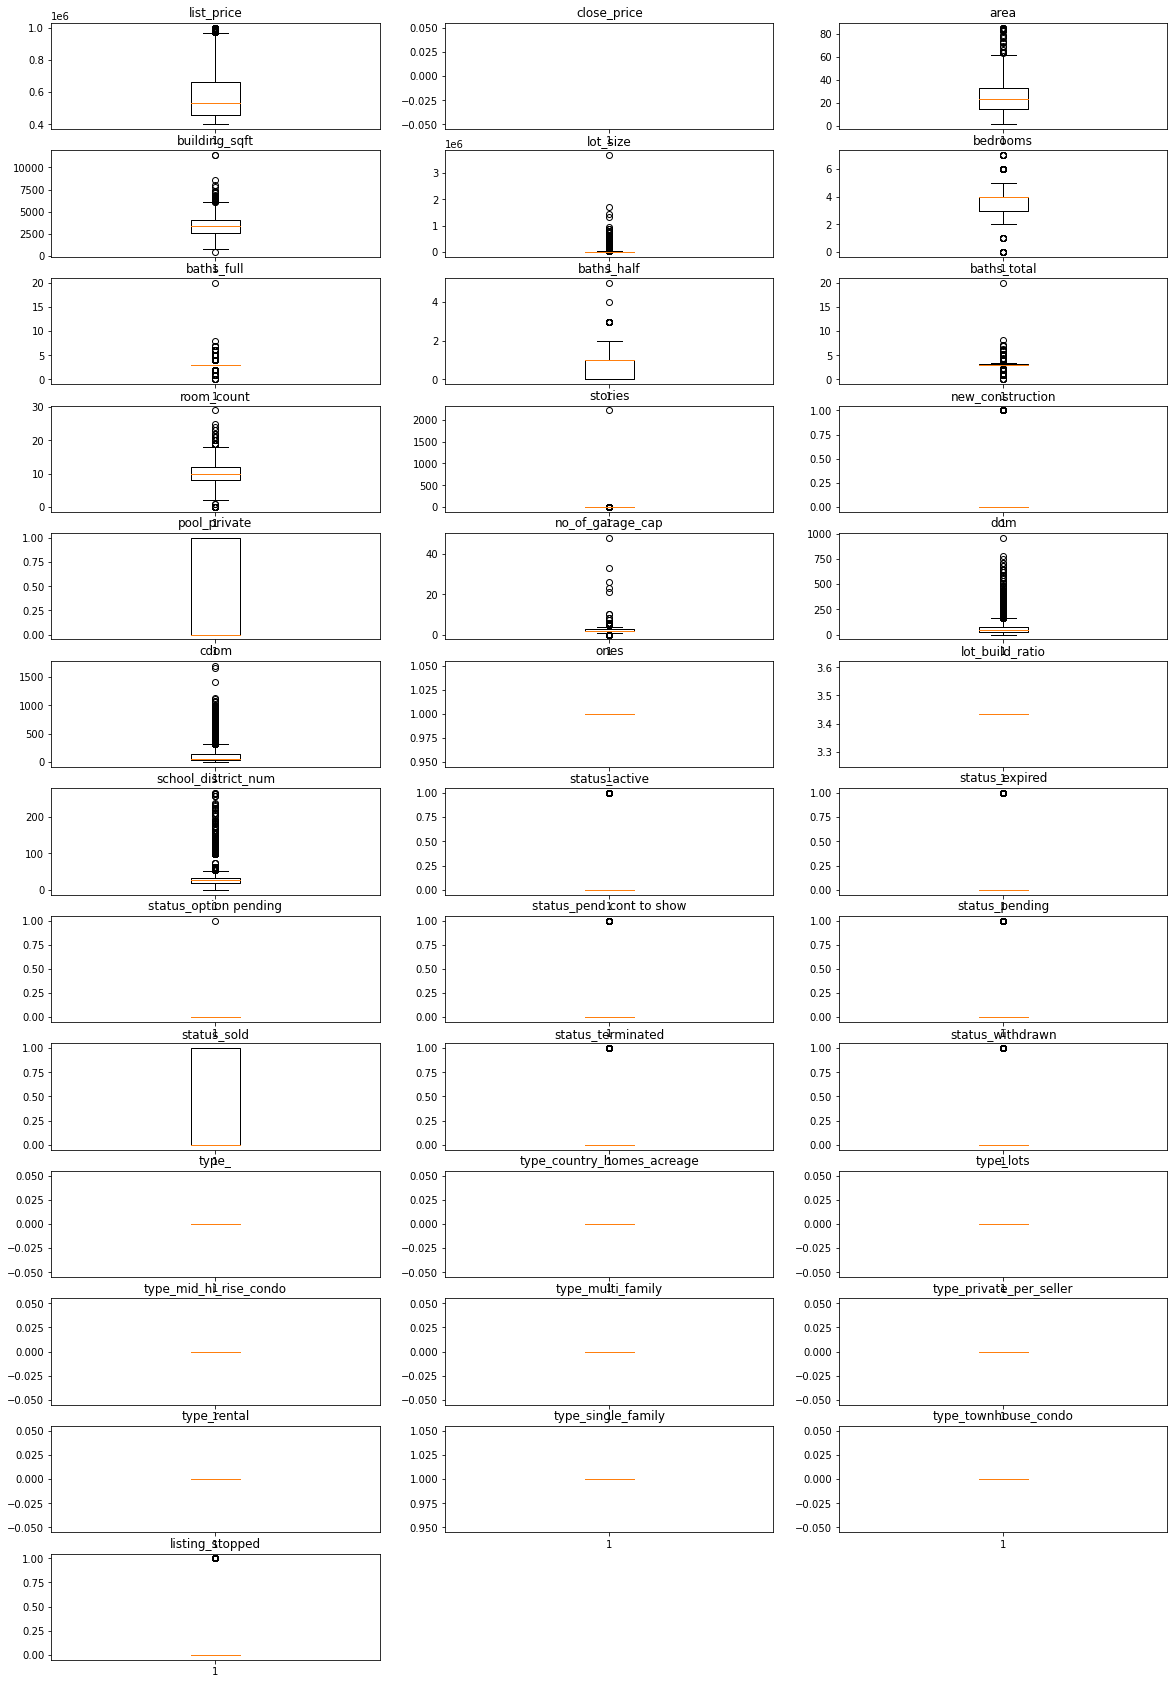

In [47]:
# Get a dict of numerial columns
col_dict = {c: i for i, c in enumerate(s2_df2_num.columns, start=1)}

# Detect outliers in each variable using box plots.
plt.figure(figsize=(20,70))

for variable,i in col_dict.items():
                     plt.subplot(30,3,i)
                     plt.boxplot(s2_df2[variable],whis=1.5)
                     plt.title(variable)
plt.show()

In [48]:
# Calculate number of outliers and its percentage in each variable using Tukey's method.
for variable in col_dict.keys():
    q75, q25 = np.percentile(s2_df2[variable], [75 ,25])
    iqr = q75 - q25
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    col_length = len(np.where(s2_df2[variable])[0])
    print("Number of outliers and percentage of it in {} : {} and {}".format(variable,
                                                len((np.where((s2_df2[variable] > max_val) | (s2_df2[variable] < min_val))[0])),
                                                len((np.where((s2_df2[variable] > max_val) | (s2_df2[variable] < min_val))[0]))*100/col_length))

Number of outliers and percentage of it in list_price : 88 and 1.8261050010375597
Number of outliers and percentage of it in close_price : 0 and 0.0
Number of outliers and percentage of it in area : 77 and 1.5978418759078648
Number of outliers and percentage of it in building_sqft : 33 and 0.6847893753890849
Number of outliers and percentage of it in lot_size : 705 and 14.632627646326277
Number of outliers and percentage of it in bedrooms : 105 and 2.184314541293946
Number of outliers and percentage of it in baths_full : 2290 and 47.56958869962609
Number of outliers and percentage of it in baths_half : 27 and 0.7516703786191536
Number of outliers and percentage of it in baths_total : 2290 and 47.54983388704319
Number of outliers and percentage of it in room_count : 55 and 1.1458333333333333
Number of outliers and percentage of it in stories : 138 and 2.8636646607179914
Number of outliers and percentage of it in new_construction : 1055 and 100.0
Number of outliers and percentage of it i

ZeroDivisionError: division by zero

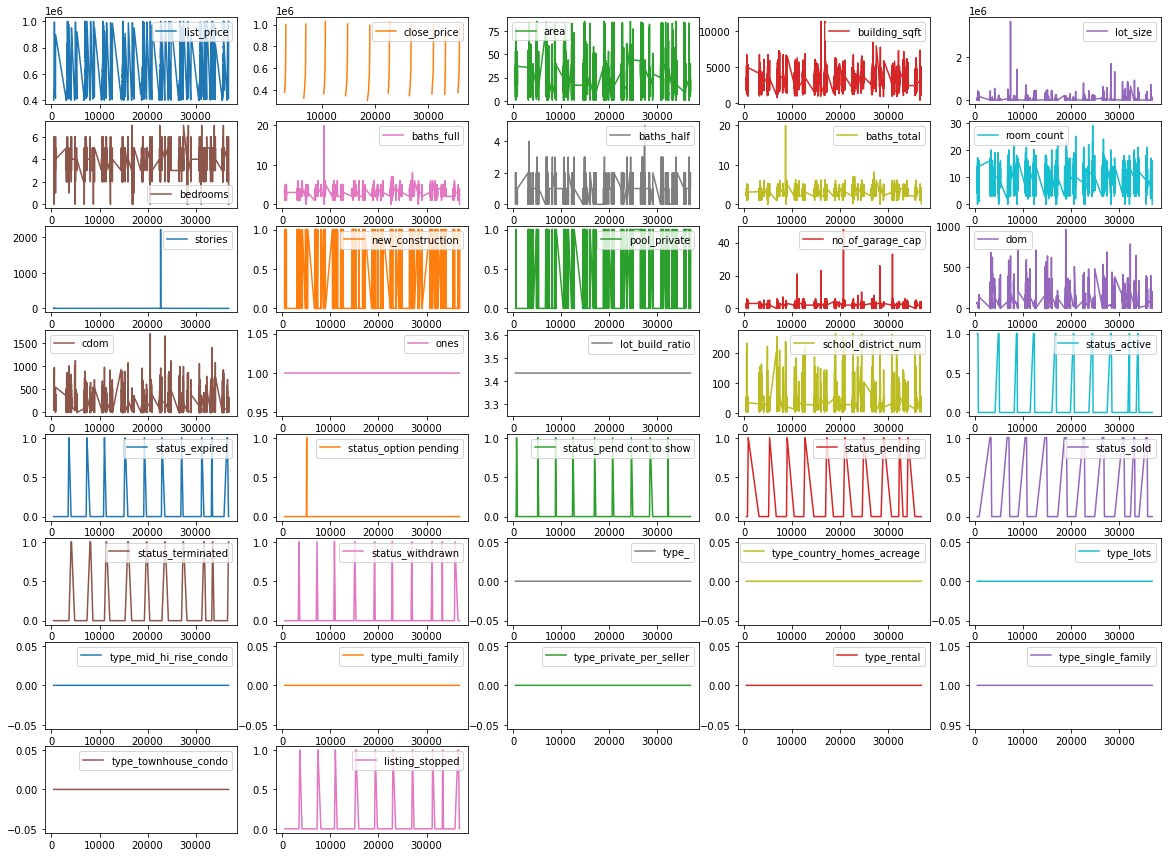

In [49]:
# Get all numerica columns
numerics = ['int_', 'int8', 'uint8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
s2_df2_num = s2_df2.select_dtypes(include=numerics)
num_cols = s2_df0_num.columns
# Plot all of them
s2_df2[num_cols].plot(subplots=True, layout=(8, 5), figsize=(20, 15), sharex=False);

## Winsorize outliers 

In [50]:
def using_mstats(s):
    return winsorize(s, limits=[0.01, 0.01])

numerics = ['int_', 'int8', 'uint8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
s2_df2_num = s2_df2.select_dtypes(include=numerics)
num_cols = s2_df2_num.columns

s2_df2[num_cols] = s2_df2[num_cols].apply(lambda x: winsorize(x, limits=[0.01, 0.01]))

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37]),
 <a list of 37 Text major ticklabel objects>)

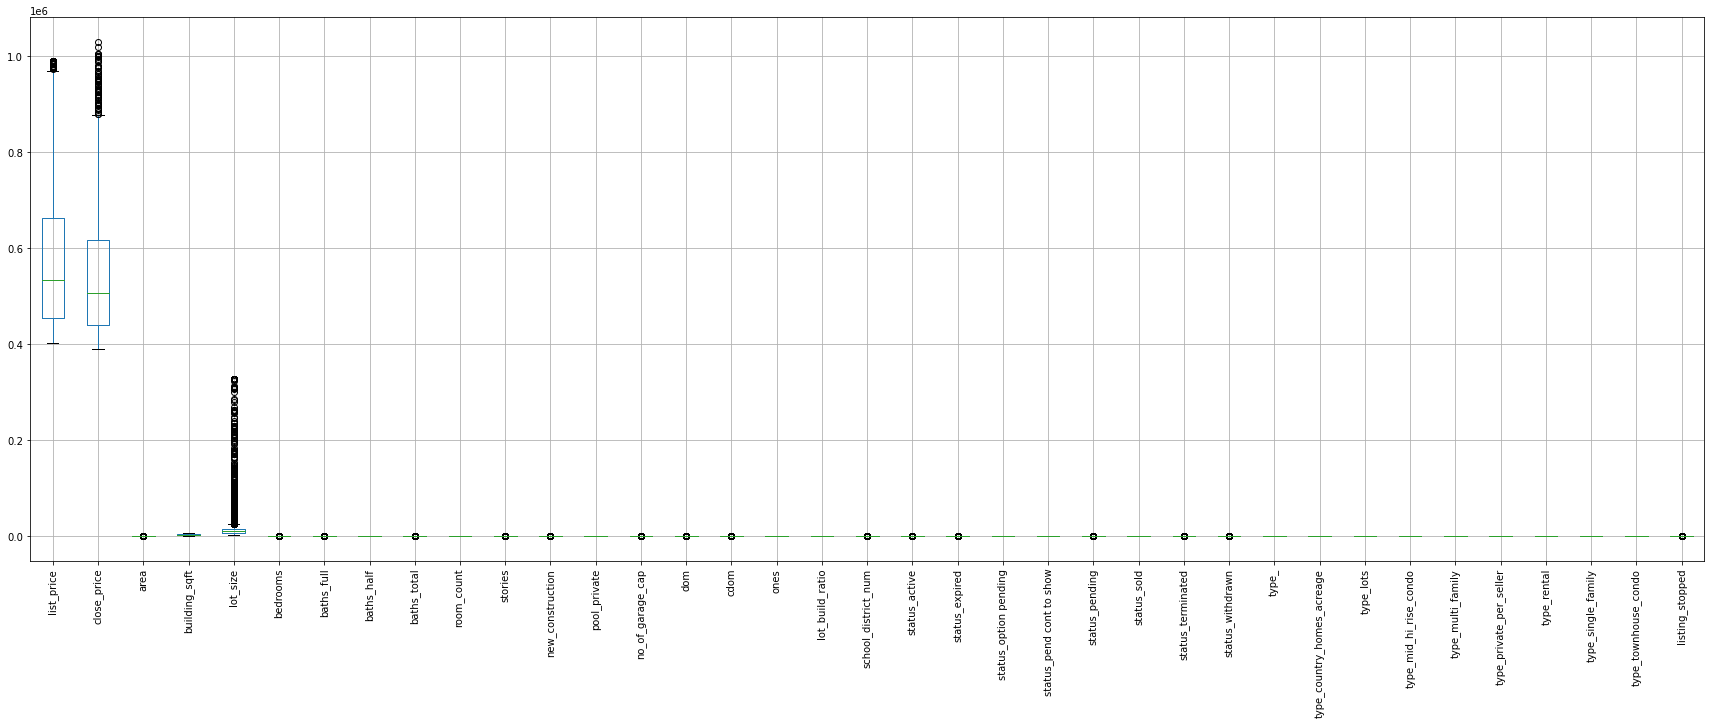

In [51]:
plt.figure(figsize = (30,10))
s2_df2.boxplot()
plt.xticks(rotation=90)

## Copy to new dataframe 

In [52]:
s2_df3 = s2_df2.copy()

In [53]:
s2_df4 = s2_df3.copy()

## Perform simple regression for predicting values 

In [54]:
data_type_summary(s2_df4)

,list_price,close_price,area,building_sqft,lot_size,bedrooms,baths_full,baths_half,baths_total,room_count,stories,new_construction,pool_private,no_of_garage_cap,dom,cdom,ones,lot_build_ratio,school_district_num,status_active,status_expired,status_option pending,status_pend cont to show,status_pending,status_sold,status_terminated,status_withdrawn,type_,type_country_homes_acreage,type_lots,type_mid_hi_rise_condo,type_multi_family,type_private_per_seller,type_rental,type_single_family,type_townhouse_condo,listing_stopped,street_number,street_name,city_location,zip_code,county,subdivision,market_area,school_district,school_elementary,school_middle,school_high,style,list_office_mlsid,list_office_name,list_agent_mlsid,list_agent_full_name,selling_office_mlsid,selling_office_name,selling_agent_mlsid,selling_agent_full_name,close_date,year_built,last_change_timestamp,list_date
count,4819,2141,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4818,4819,4819,4819,4819,4794,4673,4819,4780,4811,4814,4819,4819,4819,4819,4819,2518,2518,2518,2518,2141,4791,4819,4812
mean,576344,547447,23.9108,3359.91,22734.1,3.9116,3.03341,0.812617,3.11683,9.68707,1.86657,0.218925,0.259597,2.34011,67.5707,116.376,1,3.43483,31.0376,0.237601,0.0481428,0,0,0.0686864,0.444283,0.161859,0.0298817,0,0,0,0,0,0,0,1,0,0.0481428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,148246,137442,13.9507,969.321,46896.8,0.81016,0.802603,0.535535,0.810399,3.10926,0.677149,0.413561,0.438459,0.867469,71.561,141.938,0,4.44135e-16,24.0784,0.425658,0.21409,0,0,0.252946,0.496937,0.36836,0.170279,0,0,0,0,0,0,0,0,0,0.21409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,403000,390000,1,1280,1536,2,1,0,1.1,3,1,0,0,0,0,0,1,3.43483,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,455650,441000,14,2620,7472,3,3,0,3,8,1,0,0,2,21,29,1,3.43483,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,535000,506000,23,3348,10040,4,3,1,3.1,10,2,0,0,2,50,62,1,3.43483,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,662325,616500,33,4013,14524.5,4,3,1,3.2,12,2,0,1,3,79,146,1,3.43483,33,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,990000,1.03e+06,79,5939,328050,6,5,2,5.2,18,4,1,1,5,384,753,1,3.43483,153,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,datetime64[ns],datetime64[ns],datetime64[ns],datetime64[ns]
size,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819


In [55]:
s2_df4.select_dtypes([np.number]).columns

Index(['list_price', 'close_price', 'area', 'building_sqft', 'lot_size',
       'bedrooms', 'baths_full', 'baths_half', 'baths_total', 'room_count',
       'stories', 'new_construction', 'pool_private', 'no_of_garage_cap',
       'dom', 'cdom', 'ones', 'lot_build_ratio', 'school_district_num',
       'status_active', 'status_expired', 'status_option pending',
       'status_pend cont to show', 'status_pending', 'status_sold',
       'status_terminated', 'status_withdrawn', 'type_',
       'type_country_homes_acreage', 'type_lots', 'type_mid_hi_rise_condo',
       'type_multi_family', 'type_private_per_seller', 'type_rental',
       'type_single_family', 'type_townhouse_condo', 'listing_stopped'],
      dtype='object')

In [56]:
# Y is the target variable
Y = s2_df4['list_price']
# X is the feature set which includes
numerics = ['int_', 'int8', 'uint8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
print(numerics)
s2_df4_num = s2_df4.select_dtypes(include=numerics)
print(s2_df4_num.shape)
X = s2_df4_num.drop(['list_price', 'close_price'], axis=1)


# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

['int_', 'int8', 'uint8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
(4819, 37)

Coefficients: 
 [-7.69709010e+02  6.44549681e+01  2.08787733e-01 -3.86371318e+04
 -4.01138611e+05 -3.64357314e+04  4.29255259e+05  4.39685367e+02
  4.29618990e+03 -1.98049720e+04  2.22651500e+04 -2.51730558e+04
  4.64770810e+01  3.71468959e+01  5.07861841e-09 -4.99130692e-09
  4.02598200e+02  6.99700394e+04  2.68014890e+04  3.28145688e-09
  0.00000000e+00  5.61013121e+04  4.14772692e+04  6.99289062e+04
  5.56749907e+04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.68014890e+04]

Intercept: 
 403839.7158083725


# Gauss-Markov Theorem

## According to the Gauss–Markov theorem, in a linear regression model the ordinary least squares (OLS) estimator gives the best linear unbiased estimator (BLUE) of the coefficients, provided that

### Target variable should be a linear function of the model's coefficients
### The expectation of errors (residuals) is 0
### The errors have equal variance — homoscedasticity of errors
### Features should have low multicollinearity
### The errors are uncorrelated
### The explanatory variables and errors should be independent (exogeneity)


## Check for linearity

### The way we have specified our model here supports the linearity assumption

## Check assumption that error term should be zero on average¶

In [57]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: 2.3365200097740476e-10


### Since we have a constant term in the model, the average of the model's error is effectively zero.

## Check for the homoscedasticity assumption

## A model is homoscedastic when the distribution of its error terms (known as "scedasticity") is consistent for all predicted values. In other words, the error variance shouldn't systematically change across observations. 

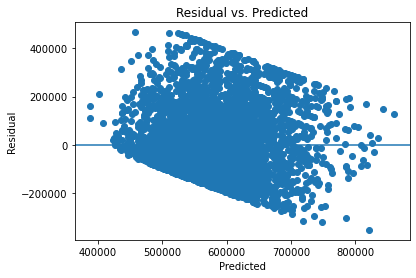

In [58]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### We can see that our error terms are not consistently distributed. 

### There are several formal statistical tests that we can use to determine whether there is heteroscedasticity in the error terms. Two of these are Barlett and Levene

### Perform Barlett and Levene tests

In [59]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2417.57 and p value is 0
Levene test statistic value is 1411.47 and p value is 2.14e-288


### The p-values of both tests is meaning we can reject the null hypothesis which again means our errors are hetetroscedastic.

## Check for low multicollinearity

### Individual features should be only weakly correlated with one another, and ideally completely uncorrelated. When features are correlated, they may both explain the same pattern of variance in the outcome. The model will attempt to find a solution, potentially by attributing half the explanatory power to one feature and half to the other. This isn’t a problem if our only goal is prediction, because then all that matters is that the variance gets explained. However, if we want to know which features matter most when predicting an outcome, multicollinearity can cause us to underestimate the relationship between features and outcomes.

#### We can simply use correlation matrix of the features to discover any multicollinearity

In [60]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r' & 'BrBG' are other good diverging colormaps

## Several coefficients are correlated 

## Check if error terms are uncorrelated as they should be 

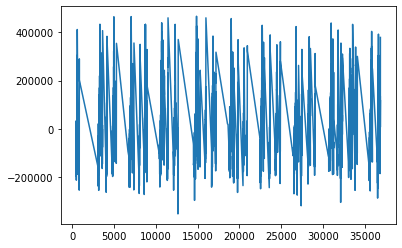

In [61]:
plt.plot(errors)
plt.show()

### Another option is to check the autocorrelation function. 

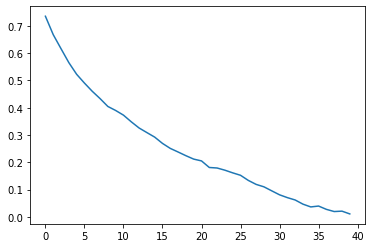

In [62]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

### We have high multicollinearity not supporting the OLS assumptions

## Check if the features are correlated with the errors. A high correlation violates the OLS assumption (exogeneity)

### This assumption, is arguably the most important one: explanatory variables and errors should be independent. If this assumption doesn't hold, then the model's predictions will be unreliable as the estimates of the coefficients would be biased. This assumption is known as the exogeneity.

In [63]:
# Convert errors to series
error_series = pd.Series(errors)
X_copy = X.copy()
X_copy['errors'] = error_series
corr = X_copy.corr()
corr.style.background_gradient(cmap='BuPu')
# 'RdBu_r' & 'BrBG' are other good diverging colormaps

## Normality of residuals

### When this assumption is violated, it causes problems with calculating confidence intervals and various significance tests for coefficients. When the error distribution significantly departs from Gaussian, confidence intervals may be too wide or too narrow. Although it is not an assumption of OLS, it still can impact our results. Specifically, normality of errors is not required to apply OLS to a linear regression model, but in order to measure the statistical significance of our estimated coefficients, error terms must be normally distributed. 

###  An informal way of doing this is by visualizing the errors in a QQ plot or to look at the histogram:

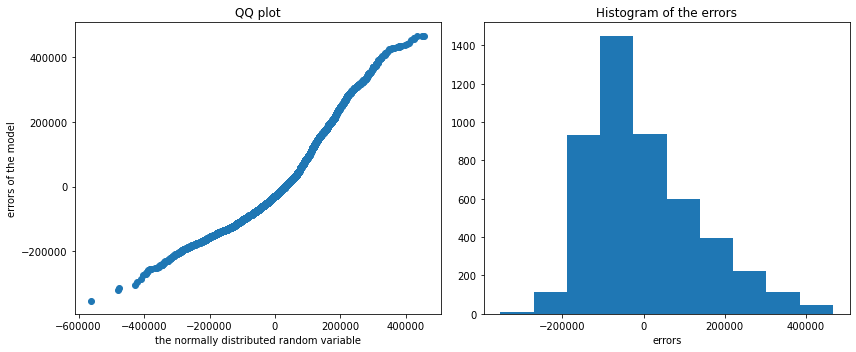

In [64]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

### Above shows that our erros are not normally distributed.

### Perform Jargue Berra and normals tests

In [65]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [66]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 649.8289627819154 and p value is 0.0
Normality test statistics is 490.95132254100736 and p value is 2.4619252845964328e-107


### The p-values of both tests are zero indicating that our errors are normally distributed.

## Statistical significance of individual coefficients

In [67]:
# Y is the target variable
Y = s2_df4['list_price']
# X is the feature set which includes
numerics = ['int_', 'int8', 'uint8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
print(numerics)
s2_df4_num = s2_df4.select_dtypes(include=numerics)
print(s2_df4_num.shape)
X = s2_df4_num.drop(['list_price', 'close_price'], axis=1)

# We add constant to the model as it's a best practice
# to do so every time!
X = sm.add_constant(X)
# We fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()
print(results.summary())

['int_', 'int8', 'uint8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
(4819, 37)
                            OLS Regression Results                            
Dep. Variable:             list_price   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     52.17
Date:                Sun, 20 Sep 2020   Prob (F-statistic):          7.28e-196
Time:                        07:03:29   Log-Likelihood:                -63720.
No. Observations:                4819   AIC:                         1.275e+05
Df Residuals:                    4797   BIC:                         1.276e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

### Most of the p-values of coefficients are close to zero indicating they are statistically signigicants. 

## Copy dataframe 

In [68]:
s2_df5 = s2_df4.copy()

## Divide the data into X and Ys before applying GridSearchCV 

In [70]:
# Y is the target variable
Y = s2_df5['list_price']

# X is the feature set which includes
numerics = ['int_', 'int8', 'uint8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
s2_df5_num = s2_df5.select_dtypes(include=numerics)
X = s2_df5_num.drop(['list_price', 'close_price'], axis=1)

X = sm.add_constant(X)
# We fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()
print(results.summary())

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

                            OLS Regression Results                            
Dep. Variable:             list_price   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     52.17
Date:                Sun, 20 Sep 2020   Prob (F-statistic):          7.28e-196
Time:                        07:03:33   Log-Likelihood:                -63720.
No. Observations:                4819   AIC:                         1.275e+05
Df Residuals:                    4797   BIC:                         1.276e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
area                

## Ridge regression  

In [71]:
alphas = np.array([1000000, 100000, 1000, 1, 0.1, 0.01, 0.001])
model = Ridge(fit_intercept = True)
grid = GridSearchCV(estimator=model, cv = 5, param_grid=dict(alpha=alphas))
grid.fit(X_train, y_train)
print(grid)
print(grid.best_score_)
print(grid.best_estimator_.alpha)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.e+06, 1.e+05, 1.e+03, 1.e+00, 1.e-01, 1.e-02, 1.e-03])})
0.16612315437785435
0.1


In [72]:
# Run the Ridge
regression = Ridge(alpha=0.1)
regression.fit(X_train, y_train)
y_pred = regression.predict(X_test)

In [73]:
# Print the regression result performance
print("--------------Ridge--------------------")
print("------- Number of Observation ---------")
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))
print("----------------------------------------")
print("----- Performance on training data -----")
regression.fit(X_train, y_train)
y_pred = regression.predict(X_train)
regression_results(y_train, y_pred)
print("----------------------------------------")
print("----- Performance on test data -----")
regression.fit(X_train, y_train)
y_pred = regression.predict(X_test)
regression_results(y_test, y_pred)
print("----------------------------------------")
print("----- Coefficients and intercept data -----")
print(regression.coef_)
print(regression.intercept_)

--------------Ridge--------------------
------- Number of Observation ---------
The number of observations in training set is 3855
The number of observations in test set is 964
----------------------------------------
----- Performance on training data -----
explained_variance:  0.1845
mean_squared_log_error:  0.0483
r2:  0.1845
MAE:  106789.9463
MSE:  18077955287.9159
RMSE:  134454.287
----------------------------------------
----- Performance on test data -----
explained_variance:  0.1867
mean_squared_log_error:  0.0449
r2:  0.1855
MAE:  103585.8207
MSE:  17235386267.485
RMSE:  131283.61
----------------------------------------
----- Coefficients and intercept data -----
[-7.41752179e+02  6.28530956e+01  2.02039129e-01 -3.79742642e+04
 -4.07692530e+05 -3.55323115e+04  4.35014922e+05  4.65291190e+02
  5.10688370e+03 -2.30335115e+04  1.82590436e+04 -2.36854181e+04
  4.59868691e+01  4.27748406e+01  0.00000000e+00  7.98502241e-21
  5.03562559e+02  5.94430609e+04  1.78154768e+04  0.000000

## Lasso regression  

In [74]:
alphas = np.array([1000000, 100000, 1000, 1, 0.1, 0.01, 0.001])
model = Lasso(fit_intercept = True)
grid = GridSearchCV(estimator=model, cv=5, param_grid=dict(alpha=alphas))
grid.fit(X_train, y_train)
print(grid)
print(grid.best_score_)
print(grid.best_estimator_.alpha)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.e+06, 1.e+05, 1.e+03, 1.e+00, 1.e-01, 1.e-02, 1.e-03])})
0.1651254307633565
0.001


In [75]:
# Run the Lasso
regression = Lasso(alpha=0.001)
regression.fit(X_train, y_train)
y_pred = regression.predict(X_test)

In [76]:
# Print the regression result performance
print("-------------Lasso----------------------")
print("------- Number of Observation ---------")
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))
print("----------------------------------------")
print("----- Performance on training data -----")
regression.fit(X_train, y_train)
y_pred = regression.predict(X_train)
regression_results(y_train, y_pred)
print("----------------------------------------")
print("----- Performance on test data -----")
regression.fit(X_train, y_train)
y_pred = regression.predict(X_test)
regression_results(y_test, y_pred)
print("----------------------------------------")
print("----- Coefficients and intercept data -----")
print(regression.coef_)
print(regression.intercept_)

-------------Lasso----------------------
------- Number of Observation ---------
The number of observations in training set is 3855
The number of observations in test set is 964
----------------------------------------
----- Performance on training data -----
explained_variance:  0.1831
mean_squared_log_error:  0.0484
r2:  0.1831
MAE:  106935.0419
MSE:  18108166676.5852
RMSE:  134566.5883
----------------------------------------
----- Performance on test data -----
explained_variance:  0.1885
mean_squared_log_error:  0.0449
r2:  0.1874
MAE:  103566.1667
MSE:  17193742641.2414
RMSE:  131124.9124
----------------------------------------
----- Coefficients and intercept data -----
[-7.42769884e+02  6.32716728e+01  2.04660985e-01 -3.85868313e+04
 -1.47282457e+05 -9.66156962e+03  1.75023723e+05  4.14091983e+02
  4.64994197e+03 -2.35441432e+04  1.81666019e+04 -2.38653045e+04
  4.43932542e+01  4.32373277e+01  0.00000000e+00  0.00000000e+00
  5.00770252e+02  6.05919262e+04  9.12772565e+03  0.0

## ElasticNet regression  

In [77]:
#alphas = np.array([1000000, 100000, 1000, 1, 0.1, 0.01, 0.001])
param_grid = {"max_iter": [1, 5, 10], "alpha":[1000000, 100000, 1000, 1, 0.1, 0.01, 0.001], "l1_ratio": np.arange(0.0, 1.0, 0.1)}

model = ElasticNet(fit_intercept = True)
grid = GridSearchCV(estimator=model, cv = 5, param_grid=param_grid)#) #dict(alpha=alphas))
grid.fit(X_train, y_train)
print(grid)
print(grid.best_score_)
print(grid.best_estimator_.max_iter)
print(grid.best_estimator_.alpha)
print(grid.best_estimator_.l1_ratio)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [1000000, 100000, 1000, 1, 0.1, 0.01, 0.001],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_iter': [1, 5, 10]})
0.16413371491473616
10
0.1
0.6000000000000001


In [78]:
# Run the ElasticNet
regression = ElasticNet(max_iter=10, alpha=0.001, l1_ratio=0.6)
regression.fit(X_train, y_train)
y_pred = regression.predict(X_test)

In [79]:
# Print the regression result performance
print("-----------ElasticNet------------------")
print("------- Number of Observation ---------")
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))
print("----------------------------------------")
print("----- Performance on training data -----")
regression.fit(X_train, y_train)
y_pred = regression.predict(X_train)
regression_results(y_train, y_pred)
print("----------------------------------------")
print("----- Performance on test data -----")
regression.fit(X_train, y_train)
y_pred = regression.predict(X_test)
regression_results(y_test, y_pred)
print("----------------------------------------")
print("----- Coefficients and intercept data -----")
print(regression.coef_)
print(regression.intercept_)

-----------ElasticNet------------------
------- Number of Observation ---------
The number of observations in training set is 3855
The number of observations in test set is 964
----------------------------------------
----- Performance on training data -----
explained_variance:  0.1808
mean_squared_log_error:  0.0485
r2:  0.1808
MAE:  107177.5591
MSE:  18160347503.4189
RMSE:  134760.3336
----------------------------------------
----- Performance on test data -----
explained_variance:  0.187
mean_squared_log_error:  0.045
r2:  0.186
MAE:  103742.5225
MSE:  17224741383.4481
RMSE:  131243.0622
----------------------------------------
----- Coefficients and intercept data -----
[-7.38295850e+02  6.29500205e+01  2.06012749e-01 -3.91277539e+04
  2.66227502e+04  7.69537455e+03  1.70507683e+03  4.21017895e+02
  4.26107774e+03 -2.44845065e+04  1.79390803e+04 -2.36776211e+04
  4.07381196e+01  4.42290719e+01  0.00000000e+00  0.00000000e+00
  5.00811180e+02  2.73700184e+04  1.32290065e+03  0.00000

## All the models perform poorly. This require additional feature engineering 

## Appending the Ridge prediction regression results back into the datafrane 

In [80]:
# Run the Ridge
ridge_regression = Ridge(alpha=0.1)
ridge_regression.fit(X_train, y_train)
ridge_predicted = ridge_regression.predict(X)
s2_df5['list_price_predicted'] = ridge_predicted

In [164]:
s2_df6['list_price_delta'] = s2_df6['list_price_predicted'] - s2_df6['list_price']
s2_df6['list_price_delta_percent'] = (s2_df6['list_price_predicted'] - s2_df6['list_price'])/s2_df6['list_price_predicted'] 

def mark_val_deviation(row):
    val = ""
    if row['list_price_delta_percent'] <= 0.05:
        val = 1 # '5%_below_mrk_val'
    elif row['list_price_delta_percent'] >= -0.05:
        val = 2 # '5%_above_mrk_val'
    elif row['list_price_delta_percent'] == 'NaN':
        val = 0 # missing value
        else:
        val = 3 # 'at_mrk_val'
    return val

s2_df6['list_price_delta_type'] = s2_df6.apply(mark_val_deviation, axis=1)

In [167]:
s2_df6.head(2)

,street_number,street_name,city_location,zip_code,county,list_price,close_price,close_date,area,subdivision,market_area,school_district,school_elementary,school_middle,school_high,building_sqft,lot_size,year_built,bedrooms,baths_full,baths_half,baths_total,room_count,stories,new_construction,pool_private,no_of_garage_cap,style,dom,cdom,list_office_mlsid,list_office_name,list_agent_mlsid,list_agent_full_name,selling_office_mlsid,selling_office_name,selling_agent_mlsid,selling_agent_full_name,last_change_timestamp,list_date,ones,lot_build_ratio,school_district_num,status_active,status_expired,status_option pending,status_pend cont to show,status_pending,status_sold,status_terminated,status_withdrawn,type_,type_country_homes_acreage,type_lots,type_mid_hi_rise_condo,type_multi_family,type_private_per_seller,type_rental,type_single_family,type_townhouse_condo,listing_stopped,list_price_predicted,list_price_delta,list_price_delta_percent,lis_price_delta_type,list_price_delta_type
468,130,mayfield,montgomery,77316,montgomery,403000.0,NaN,NaT,39.0,woodforest 63,conroe southwest,11 - conroe,stewart elementary school (conroe),peet junior high school,conroe high school,2758.0,8045.0,1970-01-01 00:00:00.000002017,4.0,3.0,0.0,3.0,7.0,2.0,0.0,0.0,3.0,traditional,65.0,65.0,rmxb05,re/max the woodlands & spring,jcm,jeffrey morris,NaN,NaN,NaN,NaN,2020-07-31 11:34:36,2020-07-02,1.0,3.434826,11.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,500653.777592,97653.777592,0.195053,0,2
469,1436,34th 1/2,houston,77018,harris,403094.0,NaN,NaT,9.0,park view at oak forest,oak forest east area,27 - houston,garden oaks elementary school,black middle school,waltrip high school,2111.0,1732.0,1970-01-01 00:00:00.000002020,3.0,3.0,1.0,3.1,5.0,3.0,1.0,0.0,3.0,"contemporary/modern, traditional",65.0,65.0,luch01,luminous custom homes,adtran,ann tran,NaN,NaN,NaN,NaN,2020-09-10 16:21:56,2020-07-03,1.0,3.434826,27.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,516108.152652,113014.152652,0.218974,0,2


In [166]:
data_type_summary(s2_df6)

,list_price,close_price,area,building_sqft,lot_size,bedrooms,baths_full,baths_half,baths_total,room_count,stories,new_construction,pool_private,no_of_garage_cap,dom,cdom,ones,lot_build_ratio,school_district_num,status_active,status_expired,status_option pending,status_pend cont to show,status_pending,status_sold,status_terminated,status_withdrawn,type_,type_country_homes_acreage,type_lots,type_mid_hi_rise_condo,type_multi_family,type_private_per_seller,type_rental,type_single_family,type_townhouse_condo,listing_stopped,list_price_predicted,list_price_delta,list_price_delta_percent,lis_price_delta_type,list_price_delta_type,street_number,street_name,city_location,zip_code,county,subdivision,market_area,school_district,school_elementary,school_middle,school_high,style,list_office_mlsid,list_office_name,list_agent_mlsid,list_agent_full_name,selling_office_mlsid,selling_office_name,selling_agent_mlsid,selling_agent_full_name,close_date,year_built,last_change_timestamp,list_date
count,4819,2141,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4818,4819,4819,4819,4819,4794,4673,4819,4780,4811,4814,4819,4819,4819,4819,4819,2518,2518,2518,2518,2141,4791,4819,4812
mean,576344,547447,23.9108,3359.91,22734.1,3.9116,3.03341,0.812617,3.11683,9.68707,1.86657,0.218925,0.259597,2.34011,67.5707,116.376,1,3.43483,31.0376,0.237601,0.0481428,0,0,0.0686864,0.444283,0.161859,0.0298817,0,0,0,0,0,0,0,1,0,0.0481428,575324,-1020.25,-0.00211895,0.496161,1.50384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,148246,137442,13.9507,969.321,46896.8,0.81016,0.802603,0.535535,0.810399,3.10926,0.677149,0.413561,0.438459,0.867469,71.561,141.938,0,4.44135e-16,24.0784,0.425658,0.21409,0,0,0.252946,0.496937,0.36836,0.170279,0,0,0,0,0,0,0,0,0,0.21409,63532.6,133836,0.230627,0.500037,0.500037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,403000,390000,1,1280,1536,2,1,0,1.1,3,1,0,0,0,0,0,1,3.43483,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,392625,-467225,-1.02064,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,455650,441000,14,2620,7472,3,3,0,3,8,1,0,0,2,21,29,1,3.43483,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,530795,-76978.3,-0.133698,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,535000,506000,23,3348,10040,4,3,1,3.1,10,2,0,0,2,50,62,1,3.43483,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,569455,29053.3,0.0517045,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,662325,616500,33,4013,14524.5,4,3,1,3.2,12,2,0,1,3,79,146,1,3.43483,33,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,614122,96145.7,0.172954,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,990000,1.03e+06,79,5939,328050,6,5,2,5.2,18,4,1,1,5,384,753,1,3.43483,153,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,1,0,1,855549,337443,0.441063,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,int64,float64,float64,float64,int64,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,datetime64[ns],datetime64[ns],datetime64[ns],datetime64[ns]
size,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,4819,481

## Try KNN classification to see if value vs list price deviation can explain why some listing get expired  

In [291]:
Y = s2_df6['listing_stopped']
X = s2_df6[['list_price', 'area', 'building_sqft', 'lot_size', 'bedrooms','baths_full', 'baths_half', 'baths_total', 'room_count', 'stories' \
    , 'new_construction', 'pool_private', 'no_of_garage_cap', 'dom', 'cdom', 'lot_build_ratio', 'school_district_num' \
    , 'list_price_delta', 'list_price_delta_percent']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

In [293]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

predictions = knn.predict(X_test)
# Get the actual values for the test set.
actual = y_test

# Compute the mean squared error of our predictions.
mse = (((predictions - actual) ** 2).sum()) / len(predictions)
print(mse)

0.05351659751037345


In [294]:
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_w.fit(X_train, y_train)

predictions = knn_w.predict(X_test)
# Get the actual values for the test set.
actual = y_test

# Compute the mean squared error of our predictions.
mse = (((predictions - actual) ** 2).sum()) / len(predictions)
print(mse)

0.051936135468749194


## Appending the KNN (weighted) classification prediction results back into the datafrane 

In [296]:
knn_predictions = knn_w.predict(X)
s2_df6['listing_stopped_predicted'] = knn_predictions
s2_df6['listing_stopped_predicted'] = s2_df6['listing_stopped_predicted'].round(0)

In [297]:
# Pivot table to check the results
pivot1 = pd.pivot_table(s2_df6,index=['listing_stopped', 'listing_stopped_predicted'],values=["list_price"], aggfunc=[len, np.mean, np.median, np.max, np.min], margins=True).round(0)

# function to pivot showing in 1000$
def format(x):
        return "${:.1f}K".format(x/1000)

# Apply function to specifc columns

lst = pivot1.columns[1:5]
for l in lst:
    pivot1[l] = pivot1[l].apply(format)

In [298]:
pivot1

len       mean     median  \
                                          list_price list_price list_price   
listing_stopped listing_stopped_predicted                                    
0               0.0                        4586.0     $576.0K    $535.0K     
                1.0                        1.0        $489.9K    $489.9K     
1               0.0                        48.0       $619.9K    $599.5K     
                1.0                        184.0      $574.5K    $514.9K     
All                                        4819.0     $576.3K    $535.0K     

                                                amax       amin  
                                          list_price list_price  
listing_stopped listing_stopped_predicted                        
0               0.0                        $990.0K    $403.0K    
                1.0                        $489.9K    $489.9K    
1               0.0                        $990.0K    $405.0K    
                1.0                        $990.0K    $403.0K    
All                                        $990.0K    $403.0K

## Decision tree

In [193]:
# Run the same model, this time with weights.
Y = s2_df6['listing_stopped']
# X is the feature set which includes
# numerics = ['int_', 'int8', 'uint8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# s2_df6_num = s2_df6.select_dtypes(include=numerics)
# X = s2_df6_num.drop(['close_price'], axis=1)

X = s2_df6[['list_price', 'area', 'building_sqft', 'lot_size', 'bedrooms','baths_full', 'baths_half', 'baths_total', 'room_count', 'stories' \
    , 'new_construction', 'pool_private', 'no_of_garage_cap', 'dom', 'cdom', 'lot_build_ratio', 'school_district_num' \
    , 'list_price_delta', 'list_price_delta_percent', 'list_price_delta_type']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

In [299]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3855, 19), (964, 19), (3855,), (964,))

51

--- 0.08075737953186035 seconds ---


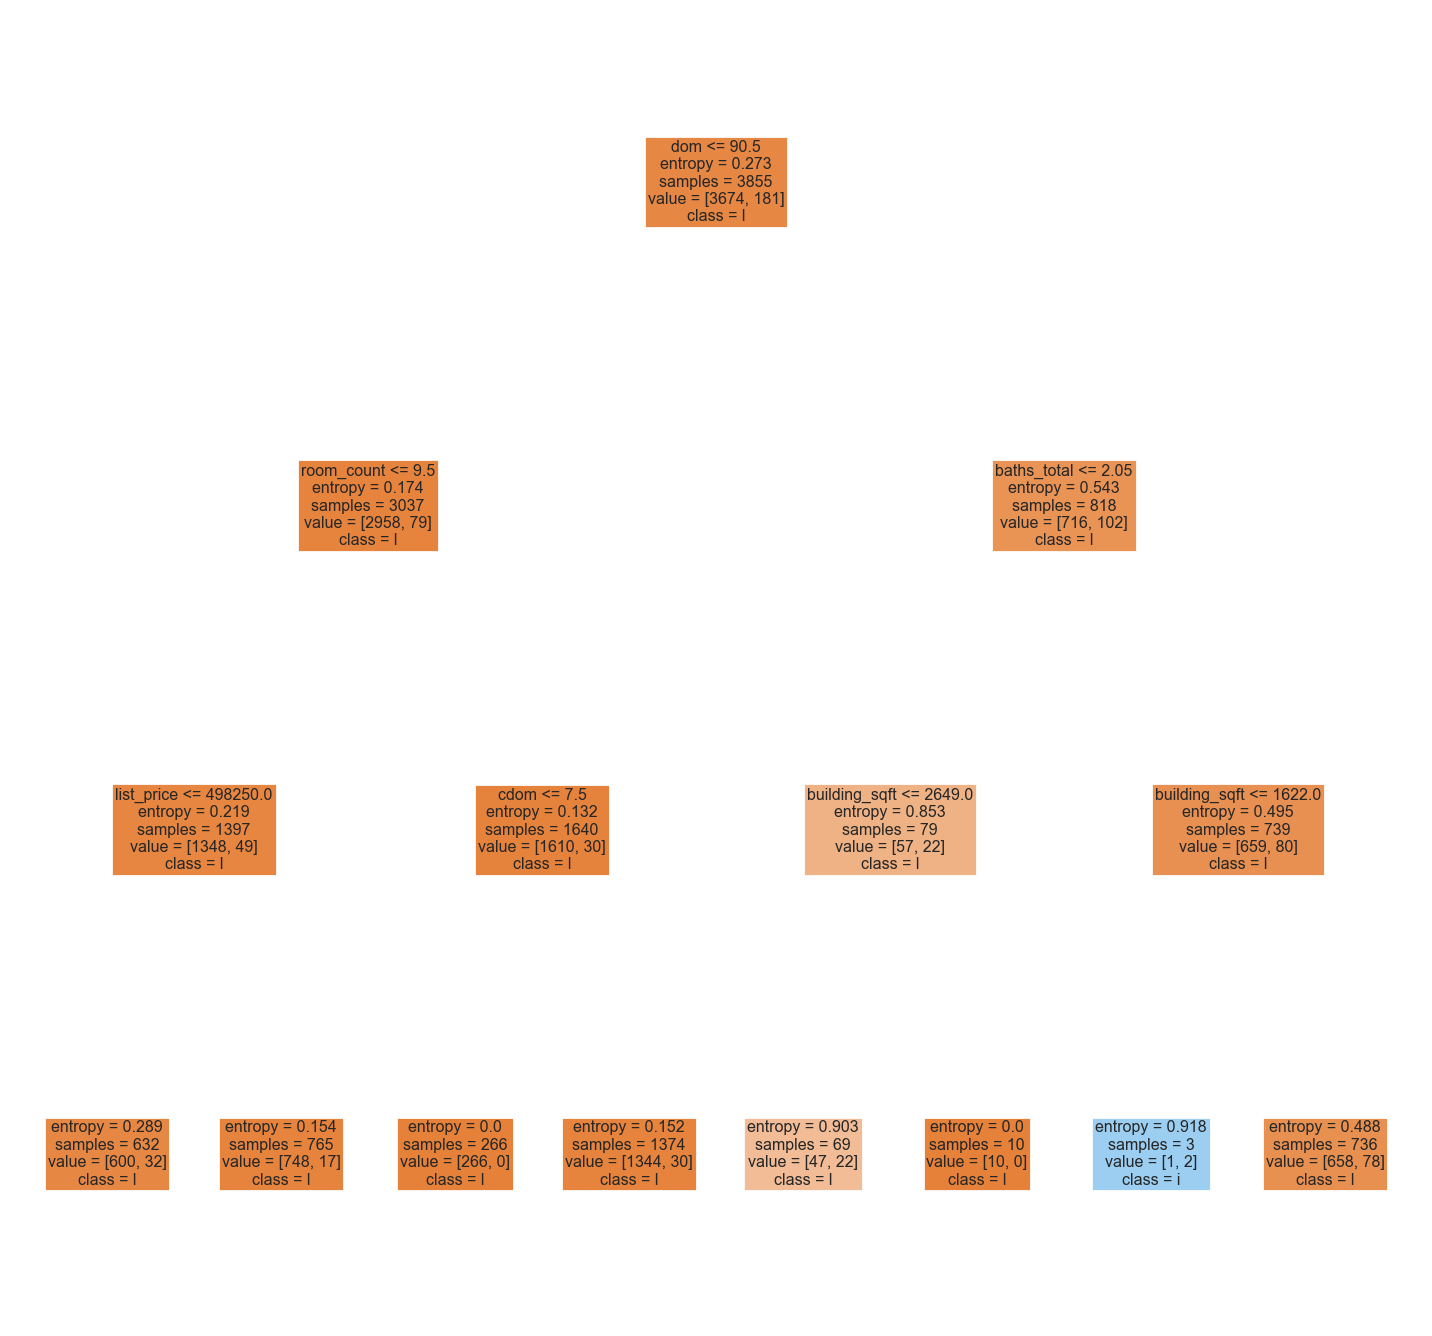

In [300]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

start_time = time.time()

# Make an instance of the Model
dt_clf = DecisionTreeClassifier(criterion='entropy',  max_features=3,  max_depth=3, random_state = 133)

# Train the model on the data
dt_clf.fit(X_train, y_train)

# Features
fn=X.columns
cn=y_train.name
# Setting dpi = 300 to make image clearer than default
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (8,8), dpi=200)
tree.plot_tree(dt_clf, feature_names = fn, class_names=cn, filled = True);

print("--- %s seconds ---" % (time.time() - start_time))

# Random forest 

In [317]:
# Create random hyperparameter grid

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 2)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 20, num = 2)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [318]:
start_time = time.time()

CV_rfc = GridSearchCV(estimator=rfc, param_grid=random_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 2313.2596707344055 seconds ---


In [319]:
# Get the best parameters
CV_rfc.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, train_labels)

In [320]:
start_time = time.time()

rf_model = RandomForestClassifier(n_estimators=200, 
                               random_state=42, 
                               max_features='auto',
                               max_depth=10,
                               min_samples_leaf=1,
                               min_samples_split=2,
                               n_jobs=-1, verbose = 1)

# Fit on training data
rf_model.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s


--- 0.6662170886993408 seconds ---


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.3s finished


In [302]:
n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in rf_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')


Average number of nodes 429
Average maximum depth 19


In [322]:
# Training predictions (to demonstrate overfitting)
train_rf_predictions = rf_model.predict(X_train)
train_rf_probs = rf_model.predict_proba(X_train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,rf_predictions))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


Accuracy for Random Forest on CV data:  0.9491701244813278


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [323]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

In [324]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    baseline['recall'] = recall_score(y_test, 
                                     [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, 
                                      [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')

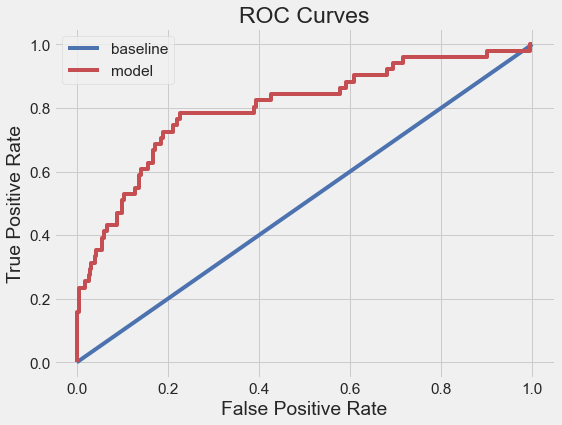

Recall Baseline: 1.0 Test: 0.04 Train: 0.28
Precision Baseline: 0.05 Test: 1.0 Train: 1.0
Roc Baseline: 0.5 Test: 0.8 Train: 1.0


<Figure size 432x288 with 0 Axes>

In [325]:
# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, rf_probs)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16

# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
plt.show();

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
plt.savefig('roc_auc_curve.png')

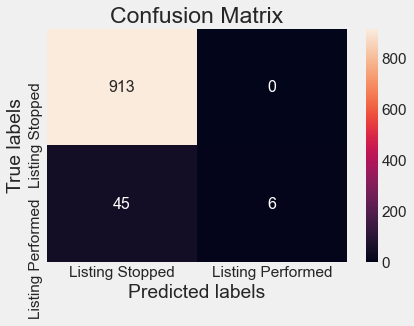

In [326]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g'); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Listing Stopped', 'Listing Performed']); ax.yaxis.set_ticklabels(['Listing Stopped', 'Listing Performed']);

In [327]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
# X = y2015.drop('loan_status', 1)
# Y = y2015['loan_status']
# X = pd.get_dummies(X)

cross_val_score(rfc, X_train, y_train, cv=5)

array([0.95330739, 0.95590143, 0.95590143, 0.95201038, 0.95201038])